<a href="https://colab.research.google.com/github/CirF-NYU/csgy_6953_final/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Attention-Enhanced DeblurGAN-v2 for Image Deblurring**
### NYU MSCS Deep Learning - Final Project
#### Chongchong Yao (cy2691@nyu.edu)

## 1. Environment Setup

In [1]:
import os
import sys
import time
import math
import numpy as np
from PIL import Image
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.utils import make_grid
from torch.cuda.amp import autocast, GradScaler

import cv2
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# Set random seeds for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 2. Data

In [2]:
class GoProDataset(Dataset):

    def __init__(self, root_dir, mode='train', transform=None, img_size=256):
        self.root_dir = root_dir
        self.mode = mode
        self.transform = transform
        self.img_size = img_size

        # Collect blur and sharp image paths
        self.blur_paths = []
        self.sharp_paths = []

        # Get all subdirectories
        data_path = os.path.join(root_dir, mode)
        subdirs = [d for d in os.listdir(data_path)
                  if os.path.isdir(os.path.join(data_path, d))]

        for subdir in subdirs:
            blur_dir = os.path.join(data_path, subdir, 'blur')
            sharp_dir = os.path.join(data_path, subdir, 'sharp')

            if os.path.exists(blur_dir) and os.path.exists(sharp_dir):
                # Get all image files
                blur_files = sorted(glob(os.path.join(blur_dir, '*.png')))
                sharp_files = sorted(glob(os.path.join(sharp_dir, '*.png')))

                # Match pairs (assuming same filenames)
                for blur_file, sharp_file in zip(blur_files, sharp_files):
                    if os.path.basename(blur_file) == os.path.basename(sharp_file):
                        self.blur_paths.append(blur_file)
                        self.sharp_paths.append(sharp_file)

        print(f"Loaded {len(self.blur_paths)} image pairs from {mode} set")

    def __len__(self):
        return len(self.blur_paths)

    def __getitem__(self, idx):
        blur_img = Image.open(self.blur_paths[idx]).convert('RGB')
        sharp_img = Image.open(self.sharp_paths[idx]).convert('RGB')

        blur_img = blur_img.resize((self.img_size, self.img_size), Image.BICUBIC)
        sharp_img = sharp_img.resize((self.img_size, self.img_size), Image.BICUBIC)

        # Convert to tensors and normalize to [-1, 1]
        transform_to_tensor = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

        blur_tensor = transform_to_tensor(blur_img)
        sharp_tensor = transform_to_tensor(sharp_img)

        return {'blur': blur_tensor, 'sharp': sharp_tensor}

    def show_sample(self, idx=0):
        sample = self.__getitem__(idx)

        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

        # Denormalize images
        blur_img = (sample['blur'].permute(1, 2, 0).numpy() * 0.5 + 0.5).clip(0, 1)
        sharp_img = (sample['sharp'].permute(1, 2, 0).numpy() * 0.5 + 0.5).clip(0, 1)

        axes[0].imshow(blur_img)
        axes[0].set_title('Blurry Image')
        axes[0].axis('off')

        axes[1].imshow(sharp_img)
        axes[1].set_title('Sharp Image')
        axes[1].axis('off')

        plt.tight_layout()
        plt.show()

## 3. Model

In [3]:
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // reduction_ratio, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // reduction_ratio, in_channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        out = torch.cat([avg_out, max_out], dim=1)
        out = self.conv(out)
        return self.sigmoid(out)

class CBAM(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_channels, reduction_ratio)
        self.spatial_attention = SpatialAttention(kernel_size)

    def forward(self, x):
        # Channel attention
        x = x * self.channel_attention(x)
        # Spatial attention
        x = x * self.spatial_attention(x)
        return x

In [4]:
class MobileNetV2_CBAM(nn.Module):
    def __init__(self, width_mult=1.0, use_cbam=True):
        super(MobileNetV2_CBAM, self).__init__()
        self.use_cbam = use_cbam

        input_channel = 32
        last_channel = 1280

        # Inverted residual settings (t=expand_ratio, c=output_channel, n=num_blocks, s=stride_first_block)
        inverted_residual_setting = [
            # t, c, n, s
            [1, 16, 1, 1], # Stage 1 (C1 output: 16)
            [6, 24, 2, 2], # Stage 2 (C2 output: 24)
            [6, 32, 3, 2], # Stage 3 (C3 output: 32)
            [6, 64, 4, 2], # Stage 4 (C4 output: 64)
            [6, 96, 3, 1], # Stage 5 (C5 output: 96)
            [6, 160, 3, 2], # Stage 6 (C6 output: 160)
            [6, 320, 1, 1], # Stage 7 (C7 output: 320)
        ]

        # Building first layer
        self.conv_initial = self.conv_bn(3, input_channel, 2) # Outputs 32 channels (C0)
        current_input_channel = input_channel # 32

        self.stages = nn.ModuleList()

        for t, c, n, s in inverted_residual_setting:
            stage = []
            output_channel = c
            for i in range(n):
                if i == 0:
                    stage.append(InvertedResidual(current_input_channel, output_channel, s, expand_ratio=t))
                else:
                    stage.append(InvertedResidual(current_input_channel, output_channel, 1, expand_ratio=t))
                current_input_channel = output_channel

            if self.use_cbam:
                stage.append(CBAM(output_channel))
            self.stages.append(nn.Sequential(*stage))

        self.last_conv = self.conv_1x1_bn(current_input_channel, last_channel)

        # Store the indices of the stages that correspond to the FPN lateral connections
        # Based on DeblurGANv2 FPN structure, it needs C1, C2, C3, C5, C7
        self.fpn_stage_indices = {
            'c1': 0, # Stage 1 (16 channels)
            'c2': 1, # Stage 2 (24 channels)
            'c3': 2, # Stage 3 (32 channels)
            'c5': 4, # Stage 5 (96 channels)
            'c7': 6, # Stage 7 (320 channels)
        }

    def conv_bn(self, inp, oup, stride):
        return nn.Sequential(
            nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
            nn.BatchNorm2d(oup),
            nn.ReLU6(inplace=True)
        )

    def conv_1x1_bn(self, inp, oup):
        return nn.Sequential(
            nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
            nn.BatchNorm2d(oup),
            nn.ReLU6(inplace=True)
        )

    def forward(self, x):
        f = self.conv_initial(x) # C0 feature (32 channels)

        # Collect features from specific stages for FPN
        features = {}

        current_output = f
        for i, stage in enumerate(self.stages):
            current_output = stage(current_output)
            if i == self.fpn_stage_indices['c1']:
                features['c1'] = current_output
            elif i == self.fpn_stage_indices['c2']:
                features['c2'] = current_output
            elif i == self.fpn_stage_indices['c3']:
                features['c3'] = current_output
            elif i == self.fpn_stage_indices['c5']:
                features['c5'] = current_output
            elif i == self.fpn_stage_indices['c7']:
                features['c7'] = current_output

        return features['c1'], features['c2'], features['c3'], features['c5'], features['c7']

class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]

        hidden_dim = int(inp * expand_ratio)
        self.use_res_connect = self.stride == 1 and inp == oup

        layers = []
        if expand_ratio != 1:
            # Pointwise
            layers.append(nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False))
            layers.append(nn.BatchNorm2d(hidden_dim))
            layers.append(nn.ReLU6(inplace=True))

        # Depthwise
        layers.append(nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1,
                                groups=hidden_dim, bias=False))
        layers.append(nn.BatchNorm2d(hidden_dim))
        layers.append(nn.ReLU6(inplace=True))

        # Pointwise linear
        layers.append(nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False))
        layers.append(nn.BatchNorm2d(oup))

        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)

In [5]:
class FPNHead(nn.Module):
    def __init__(self, num_in, num_mid, num_out):
        super().__init__()
        self.block0 = nn.Conv2d(num_in, num_mid, kernel_size=3, padding=1, bias=False)
        self.block1 = nn.Conv2d(num_mid, num_out, kernel_size=3, padding=1, bias=False)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.block0(x))
        x = self.relu(self.block1(x))
        return x

class FPN(nn.Module):
    def __init__(self, num_filters=128, use_cbam=True, pretrained=True):
        super().__init__()
        self.use_cbam = use_cbam

        # Load MobileNetV2 with CBAM
        self.backbone = MobileNetV2_CBAM(use_cbam=use_cbam)

        if pretrained:
            pass

        # Top-down connections
        self.td1 = nn.Sequential(
            nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(inplace=True)
        )
        self.td2 = nn.Sequential(
            nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(inplace=True)
        )
        self.td3 = nn.Sequential(
            nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(inplace=True)
        )

        # Lateral connections (from MobileNetV2_CBAM stages: C1, C2, C3, C5, C7)
        self.lateral4 = nn.Conv2d(320, num_filters, kernel_size=1, bias=False) # C7
        self.lateral3 = nn.Conv2d(96, num_filters, kernel_size=1, bias=False)   # C5
        self.lateral2 = nn.Conv2d(32, num_filters, kernel_size=1, bias=False)   # C3
        self.lateral1 = nn.Conv2d(24, num_filters, kernel_size=1, bias=False)   # C2
        self.lateral0 = nn.Conv2d(16, num_filters // 2, kernel_size=1, bias=False) # C1

        # Add CBAM modules in FPN if enabled
        if use_cbam:
            self.cbam4 = CBAM(num_filters)
            self.cbam3 = CBAM(num_filters)
            self.cbam2 = CBAM(num_filters)
            self.cbam1 = CBAM(num_filters)

    def forward(self, x):
        # Bottom-up pathway - get all features from backbone
        # The backbone now returns c1, c2, c3, c5, c7 directly
        # Map them to enc0, enc1, enc2, enc3, enc4 for consistency with original FPN forward logic
        enc0, enc1, enc2, enc3, enc4 = self.backbone(x) # enc0=C1, enc1=C2, enc2=C3, enc3=C5, enc4=C7

        # Lateral connections
        lateral4 = self.lateral4(enc4) # Input 320 (C7) -> num_filters
        lateral3 = self.lateral3(enc3) # Input 96 (C5) -> num_filters
        lateral2 = self.lateral2(enc2) # Input 32 (C3) -> num_filters
        lateral1 = self.lateral1(enc1) # Input 24 (C2) -> num_filters
        lateral0 = self.lateral0(enc0) # Input 16 (C1) -> num_filters // 2

        # Top-down pathway with CBAM
        map4 = lateral4
        if self.use_cbam:
            map4 = self.cbam4(map4)

        map3 = self.td1(lateral3 + F.interpolate(map4, scale_factor=2, mode='nearest'))
        if self.use_cbam:
            map3 = self.cbam3(map3)

        map2 = self.td2(lateral2 + F.interpolate(map3, scale_factor=2, mode='nearest'))
        if self.use_cbam:
            map2 = self.cbam2(map2)

        map1 = self.td3(lateral1 + F.interpolate(map2, scale_factor=2, mode='nearest'))
        if self.use_cbam:
            map1 = self.cbam1(map1)

        return lateral0, map1, map2, map3, map4

class DeblurGANv2_CBAM_Generator(nn.Module):
    def __init__(self, num_filters=64, num_filters_fpn=128, output_ch=3, use_cbam=True):
        super().__init__()

        self.fpn = FPN(num_filters=num_filters_fpn, use_cbam=use_cbam)

        # Segmentation heads
        self.head1 = FPNHead(num_filters_fpn, num_filters, num_filters)
        self.head2 = FPNHead(num_filters_fpn, num_filters, num_filters)
        self.head3 = FPNHead(num_filters_fpn, num_filters, num_filters)
        self.head4 = FPNHead(num_filters_fpn, num_filters, num_filters)

        # Smoothing layers
        self.smooth = nn.Sequential(
            nn.Conv2d(4 * num_filters, num_filters, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(inplace=True),
        )

        self.smooth2 = nn.Sequential(
            nn.Conv2d(num_filters, num_filters // 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_filters // 2),
            nn.ReLU(inplace=True),
        )

        self.final = nn.Conv2d(num_filters // 2, output_ch, kernel_size=3, padding=1)

        # Skip connection
        self.residual = True

    def forward(self, x):
        # Extract features through FPN
        map0, map1, map2, map3, map4 = self.fpn(x)

        # Process each feature map
        map4 = F.interpolate(self.head4(map4), scale_factor=8, mode='nearest')
        map3 = F.interpolate(self.head3(map3), scale_factor=4, mode='nearest')
        map2 = F.interpolate(self.head2(map2), scale_factor=2, mode='nearest')
        map1 = F.interpolate(self.head1(map1), scale_factor=1, mode='nearest')

        # Concatenate and smooth
        combined = torch.cat([map4, map3, map2, map1], dim=1)
        smoothed = self.smooth(combined)

        smoothed = F.interpolate(smoothed, scale_factor=2, mode='nearest')
        smoothed = self.smooth2(smoothed + map0)
        smoothed = F.interpolate(smoothed, scale_factor=2, mode='nearest')

        output = self.final(smoothed)

        # Residual connection
        if self.residual:
            output = torch.tanh(output) + x
            output = torch.clamp(output, -1, 1)
        else:
            output = torch.tanh(output)

        return output

In [6]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, ndf=64, n_layers=3):
        super(Discriminator, self).__init__()

        # Global discriminator (full image)
        self.global_disc = self._build_network(in_channels, ndf, n_layers)

        # Local discriminator (patch-based)
        self.local_disc = self._build_network(in_channels, ndf, n_layers)

    def _build_network(self, in_channels, ndf, n_layers):
        layers = []

        layers.append(nn.Conv2d(in_channels, ndf, kernel_size=4, stride=2, padding=1))
        layers.append(nn.LeakyReLU(0.2, inplace=True))

        nf_mult = 1
        for n in range(1, n_layers):
            nf_mult_prev = nf_mult
            nf_mult = min(2**n, 8)
            layers.extend([
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult,
                         kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(ndf * nf_mult),
                nn.LeakyReLU(0.2, inplace=True)
            ])

        nf_mult_prev = nf_mult
        nf_mult = min(2**n_layers, 8)
        layers.extend([
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult,
                     kernel_size=4, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(ndf * nf_mult),
            nn.LeakyReLU(0.2, inplace=True)
        ])

        layers.append(nn.Conv2d(ndf * nf_mult, 1, kernel_size=4, stride=1, padding=1))

        return nn.Sequential(*layers)

    def forward(self, x):
        global_out = self.global_disc(x)
        local_out = self.local_disc(x)
        return global_out, local_out

In [7]:
class VGGPerceptualLoss(nn.Module):
    def __init__(self, device='cuda'):
        super(VGGPerceptualLoss, self).__init__()

        # Load pretrained VGG19
        vgg = models.vgg19(pretrained=True).features.to(device).eval()

        # Extract features from conv3_3 layer
        self.feature_extractor = nn.Sequential()
        for i in range(21):  # Up to conv3_3
            self.feature_extractor.add_module(str(i), vgg[i])

        # Freeze parameters
        for param in self.feature_extractor.parameters():
            param.requires_grad = False

        self.criterion = nn.L1Loss()
        self.device = device

    def forward(self, fake, real):
        # Normalize images to VGG input range
        fake = (fake + 1) / 2  # [-1, 1] -> [0, 1]
        real = (real + 1) / 2

        # VGG normalization
        mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(self.device)
        std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(self.device)

        fake = (fake - mean) / std
        real = (real - mean) / std

        # Extract features
        fake_features = self.feature_extractor(fake)
        real_features = self.feature_extractor(real)

        loss = self.criterion(fake_features, real_features)
        return loss

class GANLoss(nn.Module):
    def __init__(self, gan_mode='lsgan', target_real_label=1.0, target_fake_label=0.0):
        super(GANLoss, self).__init__()
        self.register_buffer('real_label', torch.tensor(target_real_label))
        self.register_buffer('fake_label', torch.tensor(target_fake_label))
        self.gan_mode = gan_mode

        if gan_mode == 'lsgan':
            self.loss = nn.MSELoss()
        elif gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        else:
            raise NotImplementedError(f'GAN mode {gan_mode} not implemented')

    def get_target_tensor(self, prediction, target_is_real):
        if target_is_real:
            target_tensor = self.real_label
        else:
            target_tensor = self.fake_label
        return target_tensor.expand_as(prediction)

    def __call__(self, prediction, target_is_real):
        target_tensor = self.get_target_tensor(prediction, target_is_real)
        loss = self.loss(prediction, target_tensor)
        return loss

class RelativisticAverageGANLoss(nn.Module):
    def __init__(self, gan_mode='lsgan'):
        super(RelativisticAverageGANLoss, self).__init__()
        self.gan_mode = gan_mode

        if gan_mode == 'lsgan':
            self.loss = nn.MSELoss()
        elif gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()

    def forward(self, real_preds, fake_preds, discriminator_type='both'):
        if discriminator_type == 'global':
            real_pred, fake_pred = real_preds[0], fake_preds[0]
        elif discriminator_type == 'local':
            real_pred, fake_pred = real_preds[1], fake_preds[1]
        else:
            real_pred = (real_preds[0] + real_preds[1]) / 2
            fake_pred = (fake_preds[0] + fake_preds[1]) / 2

        # Relativistic average loss
        real_loss = self.loss(real_pred - fake_pred.mean(0, keepdim=True),
                             torch.ones_like(real_pred))
        fake_loss = self.loss(fake_pred - real_pred.mean(0, keepdim=True),
                             torch.zeros_like(fake_pred))

        return (real_loss + fake_loss) / 2

In [8]:
class DeblurGANv2_CBAM(nn.Module):
    def __init__(self, config):
        super(DeblurGANv2_CBAM, self).__init__()

        self.config = config
        self.device = config['device']

        # Generator
        self.generator = DeblurGANv2_CBAM_Generator(
            num_filters=config['num_filters'],
            num_filters_fpn=config['num_filters_fpn'],
            use_cbam=config['use_cbam']
        ).to(self.device)

        # Discriminators
        self.discriminator = Discriminator(
            in_channels=3,
            ndf=config['ndf'],
            n_layers=config['n_d_layers']
        ).to(self.device)

        # Loss functions
        self.perceptual_loss = VGGPerceptualLoss(device=self.device)
        self.gan_loss = RelativisticAverageGANLoss(gan_mode='lsgan')
        self.l1_loss = nn.L1Loss()

        # Optimizers
        self.g_optimizer = optim.Adam(
            self.generator.parameters(),
            lr=config['lr_g'],
            betas=(config['beta1'], config['beta2'])
        )

        self.d_optimizer = optim.Adam(
            self.discriminator.parameters(),
            lr=config['lr_d'],
            betas=(config['beta1'], config['beta2'])
        )

        # Learning rate schedulers
        self.g_scheduler = optim.lr_scheduler.StepLR(
            self.g_optimizer, step_size=config['lr_decay_step'], gamma=0.5
        )
        self.d_scheduler = optim.lr_scheduler.StepLR(
            self.d_optimizer, step_size=config['lr_decay_step'], gamma=0.5
        )

        self.scaler = torch.amp.GradScaler('cuda') if torch.cuda.is_available() else None

        print(f"Generator parameters: {sum(p.numel() for p in self.generator.parameters()):,}")
        print(f"Discriminator parameters: {sum(p.numel() for p in self.discriminator.parameters()):,}")

    def forward(self, blur_img):
        return self.generator(blur_img)

    def compute_generator_loss(self, fake_img, real_img):
        losses = {}

        # Discriminator predictions
        fake_preds = self.discriminator(fake_img)
        real_preds = self.discriminator(real_img)

        # GAN loss
        gan_loss = self.gan_loss(real_preds, fake_preds, discriminator_type='both')
        losses['gan'] = gan_loss * self.config['lambda_gan']

        # Perceptual loss
        perceptual_loss = self.perceptual_loss(fake_img, real_img)
        losses['perceptual'] = perceptual_loss * self.config['lambda_perceptual']

        # L1 loss
        l1_loss = self.l1_loss(fake_img, real_img)
        losses['l1'] = l1_loss * self.config['lambda_l1']

        # Total loss
        total_loss = sum(losses.values())
        losses['total'] = total_loss

        return losses

    def compute_discriminator_loss(self, fake_img, real_img):
        losses = {}

        # Detach fake images
        fake_img = fake_img.detach()

        # Discriminator predictions
        fake_preds = self.discriminator(fake_img)
        real_preds = self.discriminator(real_img)

        # Discriminator loss
        d_loss = self.gan_loss(real_preds, fake_preds, discriminator_type='both')
        losses['d'] = d_loss

        return losses

    def train_step(self, blur_img, sharp_img):
        blur_img = blur_img.to(self.device)
        sharp_img = sharp_img.to(self.device)

        self.g_optimizer.zero_grad()

        # Generate deblurred image
        with torch.amp.autocast('cuda'):
            fake_img = self.generator(blur_img)
            g_losses = self.compute_generator_loss(fake_img, sharp_img)

        # Backward pass for generator
        self.scaler.scale(g_losses['total']).backward()
        self.scaler.step(self.g_optimizer)

        # Train discriminator
        self.d_optimizer.zero_grad()

        with torch.amp.autocast('cuda'):
            d_losses = self.compute_discriminator_loss(fake_img, sharp_img)

        # Backward pass for discriminator
        self.scaler.scale(d_losses['d']).backward()
        self.scaler.step(self.d_optimizer)

        # Update scaler
        self.scaler.update()

        return {
            'g_loss': g_losses['total'].item(),
            'd_loss': d_losses['d'].item(),
            'fake_img': fake_img.detach()
        }

    def validate(self, blur_img, sharp_img):
        self.eval()
        with torch.no_grad():
            fake_img = self.generator(blur_img.to(self.device))

            # Compute metrics
            mse_loss = F.mse_loss(fake_img, sharp_img.to(self.device)).item()
            psnr_val = 10 * math.log10(1.0 / mse_loss) if mse_loss > 0 else 100

            # Convert to numpy for SSIM
            fake_np = (fake_img[0].cpu().numpy().transpose(1, 2, 0) * 0.5 + 0.5).clip(0, 1)
            sharp_np = (sharp_img[0].cpu().numpy().transpose(1, 2, 0) * 0.5 + 0.5).clip(0, 1)

            # SSIM
            ssim_val = ssim(fake_np, sharp_np, multichannel=True,
                           data_range=1.0, channel_axis=2)

        self.train()
        return fake_img, psnr_val, ssim_val

    def save_checkpoint(self, epoch, save_path):
        checkpoint = {
            'epoch': epoch,
            'generator_state_dict': self.generator.state_dict(),
            'discriminator_state_dict': self.discriminator.state_dict(),
            'g_optimizer_state_dict': self.g_optimizer.state_dict(),
            'd_optimizer_state_dict': self.d_optimizer.state_dict(),
            'g_scheduler_state_dict': self.g_scheduler.state_dict(),
            'd_scheduler_state_dict': self.d_scheduler.state_dict(),
            'config': self.config
        }
        torch.save(checkpoint, save_path)
        print(f"Checkpoint saved to {save_path}")

    def load_checkpoint(self, checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=self.device)

        self.generator.load_state_dict(checkpoint['generator_state_dict'])
        self.discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
        self.g_optimizer.load_state_dict(checkpoint['g_optimizer_state_dict'])
        self.d_optimizer.load_state_dict(checkpoint['d_optimizer_state_dict'])
        self.g_scheduler.load_state_dict(checkpoint['g_scheduler_state_dict'])
        self.d_scheduler.load_state_dict(checkpoint['d_scheduler_state_dict'])

        print(f"Checkpoint loaded from {checkpoint_path}, epoch {checkpoint['epoch']}")
        return checkpoint['epoch']

## 4. Training

In [9]:
# from google.colab import drive
# drive.mount('/content/drive')

# data_root = '/content/drive/MyDrive/gopro'

In [10]:
!mkdir -p data
!wget -q -nc --show-progress https://huggingface.co/datasets/snah/GOPRO_Large/resolve/main/GOPRO_Large.zip -O data/gopro.zip
!unzip -q -n data/gopro.zip -d data/

data_root = '/content/data'

In [11]:
class Trainer:
    def __init__(self, config):
        self.config = config
        self.device = config['device']

        self.model = DeblurGANv2_CBAM(config)

        self.train_dataset = GoProDataset(
            root_dir=config['data_root'],
            mode='train',
            img_size=config['img_size']
        )

        self.val_dataset = GoProDataset(
            root_dir=config['data_root'],
            mode='test',
            img_size=config['img_size']
        )

        self.train_loader = DataLoader(
            self.train_dataset,
            batch_size=config['batch_size'],
            shuffle=True,
            num_workers=config['num_workers'],
            pin_memory=True
        )

        self.val_loader = DataLoader(
            self.val_dataset,
            batch_size=config['batch_size'],
            shuffle=False,
            num_workers=config['num_workers'],
            pin_memory=True
        )

        self.train_losses = {'g': [], 'd': []}
        self.val_metrics = {'psnr': [], 'ssim': []}

        os.makedirs(config['output_dir'], exist_ok=True)
        os.makedirs(os.path.join(config['output_dir'], 'checkpoints'), exist_ok=True)
        os.makedirs(os.path.join(config['output_dir'], 'samples'), exist_ok=True)

        print(f"Training samples: {len(self.train_dataset)}")
        print(f"Validation samples: {len(self.val_dataset)}")

    def train_epoch(self, epoch):
        self.model.train()

        epoch_g_loss = 0
        epoch_d_loss = 0

        progress_bar = tqdm(self.train_loader, desc=f'Epoch {epoch}')

        for batch_idx, batch in enumerate(progress_bar):
            blur_imgs = batch['blur']
            sharp_imgs = batch['sharp']

            losses = self.model.train_step(blur_imgs, sharp_imgs)

            epoch_g_loss += losses['g_loss']
            epoch_d_loss += losses['d_loss']

            progress_bar.set_postfix({
                'G_loss': losses['g_loss'],
                'D_loss': losses['d_loss']
            })

            # Save sample images periodically
            if batch_idx % 100 == 0:
                self.save_sample_images(blur_imgs, sharp_imgs, losses['fake_img'], epoch, batch_idx)

        # Average losses
        avg_g_loss = epoch_g_loss / len(self.train_loader)
        avg_d_loss = epoch_d_loss / len(self.train_loader)

        # Update learning rate
        self.model.g_scheduler.step()
        self.model.d_scheduler.step()

        return avg_g_loss, avg_d_loss

    def validate(self, epoch):
        self.model.eval()

        total_psnr = 0
        total_ssim = 0

        with torch.no_grad():
            for batch_idx, batch in enumerate(tqdm(self.val_loader, desc='Validating')):
                blur_imgs = batch['blur']
                sharp_imgs = batch['sharp']

                fake_imgs, psnr_val, ssim_val = self.model.validate(blur_imgs[:1], sharp_imgs[:1])

                total_psnr += psnr_val
                total_ssim += ssim_val

        avg_psnr = total_psnr / len(self.val_loader)
        avg_ssim = total_ssim / len(self.val_loader)

        return avg_psnr, avg_ssim

    def save_sample_images(self, blur_imgs, sharp_imgs, fake_imgs, epoch, batch_idx):
        # Take first image from batch
        blur_img = blur_imgs[0].cpu()
        sharp_img = sharp_imgs[0].cpu()
        fake_img = fake_imgs[0].cpu()

        # Denormalize
        blur_img = blur_img * 0.5 + 0.5
        sharp_img = sharp_img * 0.5 + 0.5
        fake_img = fake_img * 0.5 + 0.5

        # Create grid
        grid = torch.stack([blur_img, fake_img, sharp_img], dim=0)
        grid = make_grid(grid, nrow=3, padding=2, normalize=False)

        # Convert to PIL and save
        grid_img = transforms.ToPILImage()(grid)
        save_path = os.path.join(
            self.config['output_dir'],
            'samples',
            f'epoch_{epoch}_batch_{batch_idx}.png'
        )
        grid_img.save(save_path)

    def plot_training_history(self):
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))

        # Losses
        axes[0].plot(self.train_losses['g'], label='Generator Loss')
        axes[0].plot(self.train_losses['d'], label='Discriminator Loss')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].set_title('Training Losses')
        axes[0].legend()
        axes[0].grid(True)

        # PSNR
        axes[1].plot(self.val_metrics['psnr'])
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('PSNR (dB)')
        axes[1].set_title('Validation PSNR')
        axes[1].grid(True)

        # SSIM
        axes[2].plot(self.val_metrics['ssim'])
        axes[2].set_xlabel('Epoch')
        axes[2].set_ylabel('SSIM')
        axes[2].set_title('Validation SSIM')
        axes[2].grid(True)

        plt.tight_layout()
        plt.savefig(os.path.join(self.config['output_dir'], 'training_history.png'))
        plt.show()

    def train(self):
        start_epoch = 0

        # Load checkpoint if exists
        checkpoint_path = os.path.join(self.config['output_dir'], 'checkpoints', 'latest.pth')
        if os.path.exists(checkpoint_path):
            start_epoch = self.model.load_checkpoint(checkpoint_path)

        print(f"Starting training from epoch {start_epoch}")

        for epoch in range(start_epoch, self.config['num_epochs']):
            print(f"\n{'='*50}")
            print(f"Epoch {epoch + 1}/{self.config['num_epochs']}")
            print(f"{'='*50}")

            # Train
            avg_g_loss, avg_d_loss = self.train_epoch(epoch + 1)
            self.train_losses['g'].append(avg_g_loss)
            self.train_losses['d'].append(avg_d_loss)

            # Validate
            if (epoch + 1) % self.config['val_freq'] == 0:
                avg_psnr, avg_ssim = self.validate(epoch + 1)
                self.val_metrics['psnr'].append(avg_psnr)
                self.val_metrics['ssim'].append(avg_ssim)

                print(f"\nValidation Results:")
                print(f"  PSNR: {avg_psnr:.2f} dB")
                print(f"  SSIM: {avg_ssim:.4f}")

            # Save checkpoint periodically
            if (epoch + 1) % self.config['save_freq'] == 0:
                checkpoint_path = os.path.join(
                    self.config['output_dir'],
                    'checkpoints',
                    f'epoch_{epoch + 1}.pth'
                )
                self.model.save_checkpoint(epoch + 1, checkpoint_path)

            # Save latest checkpoint
            latest_path = os.path.join(self.config['output_dir'], 'checkpoints', 'latest.pth')
            self.model.save_checkpoint(epoch + 1, latest_path)

            print(f"\nEpoch Summary:")
            print(f"  Generator Loss: {avg_g_loss:.4f}")
            print(f"  Discriminator Loss: {avg_d_loss:.4f}")
            if (epoch + 1) % self.config['val_freq'] == 0:
                print(f"  Validation PSNR: {avg_psnr:.2f} dB")
                print(f"  Validation SSIM: {avg_ssim:.4f}")

        self.plot_training_history()

        print("\nTraining completed!")

In [12]:
# config = {
#     # Data
#     'data_root': data_root,
#     'img_size': 256,

#     # Model
#     'use_cbam': True,
#     'num_filters': 64,
#     'num_filters_fpn': 128,
#     'ndf': 64,  # Number of discriminator filters
#     'n_d_layers': 3,  # Number of discriminator layers

#     # Training
#     'batch_size': 8,
#     'num_epochs': 40,
#     'lr_g': 1e-4,  # Generator learning rate
#     'lr_d': 4e-4,  # Discriminator learning rate
#     'beta1': 0.5,
#     'beta2': 0.999,
#     'lr_decay_step': 20,

#     # Loss weights (based on DeblurGAN-v2 paper)
#     'lambda_gan': 0.01,
#     'lambda_perceptual': 0.006,
#     'lambda_l1': 0.5,

#     # Training schedule
#     'val_freq': 1,  # Validate every N epochs
#     'save_freq': 5,  # Save checkpoint every N epochs

#     # Misc
#     'num_workers': 4,
#     'device': device,
#     'output_dir': '/content/output'
# }

In [13]:
# trainer = Trainer(config)
# trainer.train()

In [14]:
# class DeblurInference:
#     def __init__(self, checkpoint_path, device='cuda'):
#         self.device = device

#         # Load config from checkpoint
#         checkpoint = torch.load(checkpoint_path, map_location=device)
#         self.config = checkpoint['config']

#         self.model = DeblurGANv2_CBAM(self.config)
#         self.model.load_checkpoint(checkpoint_path)
#         self.model.eval()

#         print(f"Model loaded from {checkpoint_path}")

#     def deblur_image(self, image_path, save_path=None):
#         img = Image.open(image_path).convert('RGB')
#         original_size = img.size

#         # Resize to model input size
#         img_resized = img.resize((self.config['img_size'], self.config['img_size']), Image.BICUBIC)

#         # Convert to tensor
#         transform = transforms.Compose([
#             transforms.ToTensor(),
#             transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
#         ])

#         img_tensor = transform(img_resized).unsqueeze(0).to(self.device)

#         # Deblur
#         with torch.no_grad():
#             output = self.model(img_tensor)

#         # Convert back to image
#         output_img = output[0].cpu()
#         output_img = output_img * 0.5 + 0.5
#         output_img = transforms.ToPILImage()(output_img)

#         # Resize back to original size
#         output_img = output_img.resize(original_size, Image.BICUBIC)

#         if save_path:
#             output_img.save(save_path)

#         return output_img

#     def deblur_batch(self, image_paths, output_dir):
#         os.makedirs(output_dir, exist_ok=True)

#         results = []
#         for i, img_path in enumerate(tqdm(image_paths, desc='Deblurring')):
#             output_path = os.path.join(output_dir, f'deblurred_{i}.png')
#             deblurred_img = self.deblur_image(img_path, output_path)
#             results.append(deblurred_img)

#         return results

#     def compare_results(self, blur_path, deblur_path, sharp_path=None):
#         fig, axes = plt.subplots(1, 3 if sharp_path else 2, figsize=(12, 4))

#         # Blurry image
#         blur_img = Image.open(blur_path)
#         axes[0].imshow(blur_img)
#         axes[0].set_title('Blurry Image')
#         axes[0].axis('off')

#         # Deblurred image
#         deblur_img = Image.open(deblur_path)
#         axes[1].imshow(deblur_img)
#         axes[1].set_title('Deblurred Image')
#         axes[1].axis('off')

#         # Sharp image
#         if sharp_path:
#             sharp_img = Image.open(sharp_path)
#             axes[2].imshow(sharp_img)
#             axes[2].set_title('Sharp Image (Ground Truth)')
#             axes[2].axis('off')

#         plt.tight_layout()
#         plt.show()

# # Load trained model
# checkpoint_path = '/content/output/checkpoints/latest.pth'
# inference = DeblurInference(checkpoint_path)

# # Test on a single image
# test_image_path = os.path.join(config['data_root'], 'test/GOPR0854_11_00/blur/000001.png')
# deblurred = inference.deblur_image(test_image_path, '/content/deblurred_output.png')

# sharp_path = test_image_path.replace('blur', 'sharp')
# if os.path.exists(sharp_path):
#     inference.compare_results(test_image_path, '/content/deblurred_output.png', sharp_path)
# else:
#     inference.compare_results(test_image_path, '/content/deblurred_output.png')

In [15]:
# def calculate_metrics(model, test_loader, device='cuda'):
#     model.eval()

#     total_psnr = 0
#     total_ssim = 0
#     count = 0

#     with torch.no_grad():
#         for batch in tqdm(test_loader, desc='Evaluating'):
#             blur_imgs = batch['blur'].to(device)
#             sharp_imgs = batch['sharp'].to(device)

#             fake_imgs = model(blur_imgs)

#             # Calculate metrics for each image in batch
#             for i in range(blur_imgs.size(0)):
#                 # Convert to numpy
#                 fake_np = fake_imgs[i].cpu().numpy().transpose(1, 2, 0)
#                 sharp_np = sharp_imgs[i].cpu().numpy().transpose(1, 2, 0)

#                 # Denormalize from [-1, 1] to [0, 1]
#                 fake_np = (fake_np * 0.5 + 0.5).clip(0, 1)
#                 sharp_np = (sharp_np * 0.5 + 0.5).clip(0, 1)

#                 # PSNR
#                 mse = np.mean((fake_np - sharp_np) ** 2)
#                 if mse == 0:
#                     psnr_val = 100
#                 else:
#                     psnr_val = 20 * np.log10(1.0 / np.sqrt(mse))

#                 # SSIM
#                 ssim_val = ssim(fake_np, sharp_np, multichannel=True,
#                               data_range=1.0, channel_axis=2)

#                 total_psnr += psnr_val
#                 total_ssim += ssim_val
#                 count += 1

#     avg_psnr = total_psnr / count
#     avg_ssim = total_ssim / count

#     print(f"\nEvaluation Results on {count} images:")
#     print(f"Average PSNR: {avg_psnr:.2f} dB")
#     print(f"Average SSIM: {avg_ssim:.4f}")

#     return avg_psnr, avg_ssim

# test_dataset = GoProDataset(
#     root_dir=config['data_root'],
#     mode='test',
#     img_size=config['img_size']
# )

# test_loader = DataLoader(
#     test_dataset,
#     batch_size=4,
#     shuffle=False,
#     num_workers=2
# )

# avg_psnr, avg_ssim = calculate_metrics(trainer.model.generator, test_loader, device)

## 5. Comparison

In [16]:
class DeblurGANv2_Baseline_Generator(nn.Module):
    def __init__(self, num_filters=64, num_filters_fpn=128, output_ch=3):
        super().__init__()

        # Feature Pyramid Network (without CBAM)
        self.fpn = FPN(num_filters=num_filters_fpn, use_cbam=False)

        # Segmentation heads
        self.head1 = FPNHead(num_filters_fpn, num_filters, num_filters)
        self.head2 = FPNHead(num_filters_fpn, num_filters, num_filters)
        self.head3 = FPNHead(num_filters_fpn, num_filters, num_filters)
        self.head4 = FPNHead(num_filters_fpn, num_filters, num_filters)

        # Smoothing layers
        self.smooth = nn.Sequential(
            nn.Conv2d(4 * num_filters, num_filters, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(inplace=True),
        )

        self.smooth2 = nn.Sequential(
            nn.Conv2d(num_filters, num_filters // 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_filters // 2),
            nn.ReLU(inplace=True),
        )

        self.final = nn.Conv2d(num_filters // 2, output_ch, kernel_size=3, padding=1)

        # Skip connection
        self.residual = True

    def forward(self, x):
        # Extract features through FPN
        map0, map1, map2, map3, map4 = self.fpn(x)

        # Process each feature map
        map4 = F.interpolate(self.head4(map4), scale_factor=8, mode='nearest')
        map3 = F.interpolate(self.head3(map3), scale_factor=4, mode='nearest')
        map2 = F.interpolate(self.head2(map2), scale_factor=2, mode='nearest')
        map1 = F.interpolate(self.head1(map1), scale_factor=1, mode='nearest')

        # Concatenate and smooth
        combined = torch.cat([map4, map3, map2, map1], dim=1)
        smoothed = self.smooth(combined)

        smoothed = F.interpolate(smoothed, scale_factor=2, mode='nearest')
        smoothed = self.smooth2(smoothed + map0)
        smoothed = F.interpolate(smoothed, scale_factor=2, mode='nearest')

        output = self.final(smoothed)

        # Residual connection
        if self.residual:
            output = torch.tanh(output) + x
            output = torch.clamp(output, -1, 1)
        else:
            output = torch.tanh(output)

        return output

class DeblurGANv2_Baseline(nn.Module):
    def __init__(self, config):
        super(DeblurGANv2_Baseline, self).__init__()

        self.config = config
        self.device = config['device']

        # Generator (without CBAM)
        self.generator = DeblurGANv2_Baseline_Generator(
            num_filters=config['num_filters'],
            num_filters_fpn=config['num_filters_fpn']
        ).to(self.device)

        # Discriminators
        self.discriminator = Discriminator(
            in_channels=3,
            ndf=config['ndf'],
            n_layers=config['n_d_layers']
        ).to(self.device)

        # Loss functions
        self.perceptual_loss = VGGPerceptualLoss(device=self.device)
        self.gan_loss = RelativisticAverageGANLoss(gan_mode='lsgan')
        self.l1_loss = nn.L1Loss()

        # Optimizers
        self.g_optimizer = optim.Adam(
            self.generator.parameters(),
            lr=config['lr_g'],
            betas=(config['beta1'], config['beta2'])
        )

        self.d_optimizer = optim.Adam(
            self.discriminator.parameters(),
            lr=config['lr_d'],
            betas=(config['beta1'], config['beta2'])
        )

        # Learning rate schedulers
        self.g_scheduler = optim.lr_scheduler.StepLR(
            self.g_optimizer, step_size=config['lr_decay_step'], gamma=0.5
        )
        self.d_scheduler = optim.lr_scheduler.StepLR(
            self.d_optimizer, step_size=config['lr_decay_step'], gamma=0.5
        )

        self.scaler = torch.amp.GradScaler('cuda') if torch.cuda.is_available() else None

        print(f"Baseline Generator parameters: {sum(p.numel() for p in self.generator.parameters()):,}")
        print(f"Discriminator parameters: {sum(p.numel() for p in self.discriminator.parameters()):,}")

    def forward(self, blur_img):
        return self.generator(blur_img)

    def compute_generator_loss(self, fake_img, real_img):
        losses = {}

        # Discriminator predictions
        fake_preds = self.discriminator(fake_img)
        real_preds = self.discriminator(real_img)

        # GAN loss
        gan_loss = self.gan_loss(real_preds, fake_preds, discriminator_type='both')
        losses['gan'] = gan_loss * self.config['lambda_gan']

        # Perceptual loss
        perceptual_loss = self.perceptual_loss(fake_img, real_img)
        losses['perceptual'] = perceptual_loss * self.config['lambda_perceptual']

        # L1 loss
        l1_loss = self.l1_loss(fake_img, real_img)
        losses['l1'] = l1_loss * self.config['lambda_l1']

        # Total loss
        total_loss = sum(losses.values())
        losses['total'] = total_loss

        return losses

    def compute_discriminator_loss(self, fake_img, real_img):
        losses = {}

        # Detach fake images to stop gradient flow to generator
        fake_img = fake_img.detach()

        # Get predictions
        fake_preds = self.discriminator(fake_img)
        real_preds = self.discriminator(real_img)

        # Discriminator loss
        d_loss = self.gan_loss(real_preds, fake_preds, discriminator_type='both')
        losses['d'] = d_loss

        return losses

    def train_step(self, blur_img, sharp_img):
        blur_img = blur_img.to(self.device)
        sharp_img = sharp_img.to(self.device)

        # Train generator
        self.g_optimizer.zero_grad()

        # Generate fake image with autocast
        with torch.amp.autocast('cuda'):
            fake_img = self.generator(blur_img)
            g_losses = self.compute_generator_loss(fake_img, sharp_img)

        # Backward pass for generator
        self.scaler.scale(g_losses['total']).backward()
        self.scaler.step(self.g_optimizer)

        # Train discriminator
        self.d_optimizer.zero_grad()

        with torch.amp.autocast('cuda'):
            d_losses = self.compute_discriminator_loss(fake_img, sharp_img)

        # Backward pass for discriminator
        self.scaler.scale(d_losses['d']).backward()
        self.scaler.step(self.d_optimizer)

        # Update scaler
        self.scaler.update()

        return {
            'g_loss': g_losses['total'].item(),
            'd_loss': d_losses['d'].item(),
            'fake_img': fake_img.detach()
        }

    def validate(self, blur_img, sharp_img):
        self.eval()
        with torch.no_grad():
            fake_img = self.generator(blur_img.to(self.device))

            # Compute metrics
            mse_loss = F.mse_loss(fake_img, sharp_img.to(self.device)).item()
            psnr_val = 10 * math.log10(1.0 / mse_loss) if mse_loss > 0 else 100

            # Convert to numpy for SSIM
            fake_np = (fake_img[0].cpu().numpy().transpose(1, 2, 0) * 0.5 + 0.5).clip(0, 1)
            sharp_np = (sharp_img[0].cpu().numpy().transpose(1, 2, 0) * 0.5 + 0.5).clip(0, 1)

            # SSIM
            ssim_val = ssim(fake_np, sharp_np, multichannel=True,
                           data_range=1.0, channel_axis=2)

        self.train()
        return fake_img, psnr_val, ssim_val

    def save_checkpoint(self, epoch, save_path):
        checkpoint = {
            'epoch': epoch,
            'generator_state_dict': self.generator.state_dict(),
            'discriminator_state_dict': self.discriminator.state_dict(),
            'g_optimizer_state_dict': self.g_optimizer.state_dict(),
            'd_optimizer_state_dict': self.d_optimizer.state_dict(),
            'g_scheduler_state_dict': self.g_scheduler.state_dict(),
            'd_scheduler_state_dict': self.d_scheduler.state_dict(),
            'config': self.config
        }
        torch.save(checkpoint, save_path)
        print(f"Checkpoint saved to {save_path}")

    def load_checkpoint(self, checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=self.device)

        self.generator.load_state_dict(checkpoint['generator_state_dict'])
        self.discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
        self.g_optimizer.load_state_dict(checkpoint['g_optimizer_state_dict'])
        self.d_optimizer.load_state_dict(checkpoint['d_optimizer_state_dict'])
        self.g_scheduler.load_state_dict(checkpoint['g_scheduler_state_dict'])
        self.d_scheduler.load_state_dict(checkpoint['d_scheduler_state_dict'])

        print(f"Checkpoint loaded from {checkpoint_path}, epoch {checkpoint['epoch']}")
        return checkpoint['epoch']

In [17]:
class BaselineTrainer(Trainer):
    def __init__(self, config):
        config_copy = config.copy()
        config_copy['use_cbam'] = False

        os.makedirs(config_copy['output_dir'], exist_ok=True)
        os.makedirs(os.path.join(config_copy['output_dir'], 'checkpoints'), exist_ok=True)
        os.makedirs(os.path.join(config_copy['output_dir'], 'samples'), exist_ok=True)

        self.config = config_copy

        self.train_dataset = GoProDataset(
            root_dir=config_copy['data_root'],
            mode='train',
            img_size=config_copy['img_size']
        )

        self.val_dataset = GoProDataset(
            root_dir=config_copy['data_root'],
            mode='test',
            img_size=config_copy['img_size']
        )

        self.train_loader = DataLoader(
            self.train_dataset,
            batch_size=config_copy['batch_size'],
            shuffle=True,
            num_workers=config_copy['num_workers'],
            pin_memory=True
        )

        self.val_loader = DataLoader(
            self.val_dataset,
            batch_size=config_copy['batch_size'],
            shuffle=False,
            num_workers=config_copy['num_workers'],
            pin_memory=True
        )

        self.device = config_copy['device']
        self.model = DeblurGANv2_Baseline(config_copy).to(self.device)

        self.train_losses = {'g': [], 'd': []}
        self.val_metrics = {'psnr': [], 'ssim': []}

        print(f"Training baseline model (without CBAM)")
        print(f"Training samples: {len(self.train_dataset)}")
        print(f"Validation samples: {len(self.val_dataset)}")
        print(f"Output directory: {config_copy['output_dir']}")

In [18]:
class ComparativeExperiment:
    def __init__(self, config):
        self.config = config
        self.device = config['device']

        self.cbam_output_dir = os.path.join(config['output_dir'], 'cbam')
        self.baseline_output_dir = os.path.join(config['output_dir'], 'baseline')

        os.makedirs(self.cbam_output_dir, exist_ok=True)
        os.makedirs(self.baseline_output_dir, exist_ok=True)

        self.train_dataset = GoProDataset(
            root_dir=config['data_root'],
            mode='train',
            img_size=config['img_size']
        )

        self.val_dataset = GoProDataset(
            root_dir=config['data_root'],
            mode='test',
            img_size=config['img_size']
        )

        self.train_loader = DataLoader(
            self.train_dataset,
            batch_size=config['batch_size'],
            shuffle=True,
            num_workers=config['num_workers'],
            pin_memory=True
        )

        self.val_loader = DataLoader(
            self.val_dataset,
            batch_size=config['batch_size'],
            shuffle=False,
            num_workers=config['num_workers'],
            pin_memory=True
        )

        self.results = {
            'cbam': {'train_losses': [], 'val_psnr': [], 'val_ssim': [], 'params': 0},
            'baseline': {'train_losses': [], 'val_psnr': [], 'val_ssim': [], 'params': 0}
        }

    def train_models(self, num_epochs=50):
        # Configuration for training
        train_config = self.config.copy()

        print("=" * 60)
        print("Training CBAM-enhanced model")
        print("=" * 60)

        cbam_config = train_config.copy()
        cbam_config['use_cbam'] = True
        cbam_config['output_dir'] = self.cbam_output_dir
        cbam_config['num_epochs'] = num_epochs

        cbam_trainer = Trainer(cbam_config)
        cbam_trainer.train()

        self.results['cbam']['train_losses'] = cbam_trainer.train_losses['g']
        self.results['cbam']['val_psnr'] = cbam_trainer.val_metrics['psnr']
        self.results['cbam']['val_ssim'] = cbam_trainer.val_metrics['ssim']
        self.results['cbam']['params'] = sum(p.numel() for p in cbam_trainer.model.generator.parameters())

        print("\n" + "=" * 60)
        print("Training Baseline model (without CBAM)")
        print("=" * 60)

        baseline_config = train_config.copy()
        baseline_config['use_cbam'] = False
        baseline_config['output_dir'] = self.baseline_output_dir
        baseline_config['num_epochs'] = num_epochs

        baseline_trainer = BaselineTrainer(baseline_config)
        baseline_trainer.train()

        self.results['baseline']['train_losses'] = baseline_trainer.train_losses['g']
        self.results['baseline']['val_psnr'] = baseline_trainer.val_metrics['psnr']
        self.results['baseline']['val_ssim'] = baseline_trainer.val_metrics['ssim']
        self.results['baseline']['params'] = sum(p.numel() for p in baseline_trainer.model.generator.parameters())

        print("\n" + "=" * 60)
        print("Training completed for both models")
        print("=" * 60)

    def evaluate_models(self):
        print("\n" + "=" * 60)
        print("Evaluating both models on test set")
        print("=" * 60)

        # Load best checkpoints
        cbam_checkpoint = torch.load(
            os.path.join(self.cbam_output_dir, 'checkpoints', 'latest.pth'),
            map_location=self.device
        )

        baseline_checkpoint = torch.load(
            os.path.join(self.baseline_output_dir, 'checkpoints', 'latest.pth'),
            map_location=self.device
        )

        cbam_config = self.config.copy()
        cbam_config['use_cbam'] = True
        cbam_model = DeblurGANv2_CBAM(cbam_config)
        cbam_model.load_checkpoint(os.path.join(self.cbam_output_dir, 'checkpoints', 'latest.pth'))
        cbam_generator = cbam_model.generator.eval()

        baseline_config = self.config.copy()
        baseline_config['use_cbam'] = False
        baseline_model = DeblurGANv2_Baseline(baseline_config)
        baseline_model.load_checkpoint(os.path.join(self.baseline_output_dir, 'checkpoints', 'latest.pth'))
        baseline_generator = baseline_model.generator.eval()

        cbam_psnr_list, cbam_ssim_list = [], []
        baseline_psnr_list, baseline_ssim_list = [], []

        with torch.no_grad():
            for batch_idx, batch in enumerate(tqdm(self.val_loader, desc='Evaluating')):
                blur_imgs = batch['blur'].to(self.device)
                sharp_imgs = batch['sharp'].to(self.device)

                cbam_output = cbam_generator(blur_imgs)
                baseline_output = baseline_generator(blur_imgs)

                # Calculate metrics for each image in batch
                for i in range(blur_imgs.size(0)):
                    # Convert to numpy
                    cbam_np = cbam_output[i].cpu().numpy().transpose(1, 2, 0)
                    baseline_np = baseline_output[i].cpu().numpy().transpose(1, 2, 0)
                    sharp_np = sharp_imgs[i].cpu().numpy().transpose(1, 2, 0)

                    # Denormalize from [-1, 1] to [0, 1]
                    cbam_np = (cbam_np * 0.5 + 0.5).clip(0, 1)
                    baseline_np = (baseline_np * 0.5 + 0.5).clip(0, 1)
                    sharp_np = (sharp_np * 0.5 + 0.5).clip(0, 1)

                    # PSNR
                    cbam_mse = np.mean((cbam_np - sharp_np) ** 2)
                    baseline_mse = np.mean((baseline_np - sharp_np) ** 2)

                    cbam_psnr = 20 * np.log10(1.0 / np.sqrt(cbam_mse)) if cbam_mse > 0 else 100
                    baseline_psnr = 20 * np.log10(1.0 / np.sqrt(baseline_mse)) if baseline_mse > 0 else 100

                    # SSIM
                    cbam_ssim = ssim(cbam_np, sharp_np, multichannel=True,
                                    data_range=1.0, channel_axis=2)
                    baseline_ssim = ssim(baseline_np, sharp_np, multichannel=True,
                                        data_range=1.0, channel_axis=2)

                    cbam_psnr_list.append(cbam_psnr)
                    cbam_ssim_list.append(cbam_ssim)
                    baseline_psnr_list.append(baseline_psnr)
                    baseline_ssim_list.append(baseline_ssim)

        cbam_avg_psnr = np.mean(cbam_psnr_list)
        cbam_avg_ssim = np.mean(cbam_ssim_list)
        baseline_avg_psnr = np.mean(baseline_psnr_list)
        baseline_avg_ssim = np.mean(baseline_ssim_list)

        self.results['cbam']['test_psnr'] = cbam_avg_psnr
        self.results['cbam']['test_ssim'] = cbam_avg_ssim
        self.results['baseline']['test_psnr'] = baseline_avg_psnr
        self.results['baseline']['test_ssim'] = baseline_avg_ssim

        print("\n" + "=" * 60)
        print("MODEL COMPARISON RESULTS")
        print("=" * 60)
        print(f"{'Metric':<15} {'CBAM Model':<15} {'Baseline Model':<15} {'Improvement':<15}")
        print("-" * 60)
        print(f"{'PSNR (dB)':<15} {cbam_avg_psnr:<15.2f} {baseline_avg_psnr:<15.2f} {cbam_avg_psnr - baseline_avg_psnr:<+.2f}")
        print(f"{'SSIM':<15} {cbam_avg_ssim:<15.4f} {baseline_avg_ssim:<15.4f} {cbam_avg_ssim - baseline_avg_ssim:<+.4f}")
        print(f"{'Parameters':<15} {self.results['cbam']['params']:<15,} {self.results['baseline']['params']:<15,} "
              f"{self.results['cbam']['params'] - self.results['baseline']['params']:<+,}")
        print("=" * 60)

        return cbam_avg_psnr, cbam_avg_ssim, baseline_avg_psnr, baseline_avg_ssim

    def visualize_comparison(self, num_samples=5):
        print("\n" + "=" * 60)
        print(f"Visualizing comparison on {num_samples} samples")
        print("=" * 60)

        # Load models
        cbam_config = self.config.copy()
        cbam_config['use_cbam'] = True
        cbam_model = DeblurGANv2_CBAM(cbam_config)
        cbam_model.load_checkpoint(os.path.join(self.cbam_output_dir, 'checkpoints', 'latest.pth'))
        cbam_generator = cbam_model.generator.eval()

        baseline_config = self.config.copy()
        baseline_config['use_cbam'] = False
        baseline_model = DeblurGANv2_Baseline(baseline_config)
        baseline_model.load_checkpoint(os.path.join(self.baseline_output_dir, 'checkpoints', 'latest.pth'))
        baseline_generator = baseline_model.generator.eval()

        # Get random samples from validation set
        indices = np.random.choice(len(self.val_dataset), num_samples, replace=False)

        for i, idx in enumerate(indices):
            sample = self.val_dataset[idx]
            blur_img = sample['blur'].unsqueeze(0).to(self.device)
            sharp_img = sample['sharp'].unsqueeze(0).to(self.device)

            # Generate deblurred images
            with torch.no_grad():
                cbam_output = cbam_generator(blur_img)
                baseline_output = baseline_generator(blur_img)

            # Convert to numpy for visualization
            blur_np = (blur_img[0].cpu().numpy().transpose(1, 2, 0) * 0.5 + 0.5).clip(0, 1)
            sharp_np = (sharp_img[0].cpu().numpy().transpose(1, 2, 0) * 0.5 + 0.5).clip(0, 1)
            cbam_np = (cbam_output[0].cpu().numpy().transpose(1, 2, 0) * 0.5 + 0.5).clip(0, 1)
            baseline_np = (baseline_output[0].cpu().numpy().transpose(1, 2, 0) * 0.5 + 0.5).clip(0, 1)

            # Calculate metrics for this sample
            cbam_mse = np.mean((cbam_np - sharp_np) ** 2)
            baseline_mse = np.mean((baseline_np - sharp_np) ** 2)

            cbam_psnr = 20 * np.log10(1.0 / np.sqrt(cbam_mse)) if cbam_mse > 0 else 100
            baseline_psnr = 20 * np.log10(1.0 / np.sqrt(baseline_mse)) if baseline_mse > 0 else 100

            cbam_ssim = ssim(cbam_np, sharp_np, multichannel=True, data_range=1.0, channel_axis=2)
            baseline_ssim = ssim(baseline_np, sharp_np, multichannel=True, data_range=1.0, channel_axis=2)

            fig, axes = plt.subplots(1, 4, figsize=(16, 4))

            axes[0].imshow(blur_np)
            axes[0].set_title('Blurry Input')
            axes[0].axis('off')

            axes[1].imshow(baseline_np)
            axes[1].set_title(f'Baseline\nPSNR: {baseline_psnr:.2f}dB, SSIM: {baseline_ssim:.4f}')
            axes[1].axis('off')

            axes[2].imshow(cbam_np)
            axes[2].set_title(f'CBAM-enhanced\nPSNR: {cbam_psnr:.2f}dB, SSIM: {cbam_ssim:.4f}')
            axes[2].axis('off')

            axes[3].imshow(sharp_np)
            axes[3].set_title('Ground Truth')
            axes[3].axis('off')

            plt.suptitle(f'Sample {i+1} - Comparison Results', fontsize=14, fontweight='bold')
            plt.tight_layout()
            plt.show()

    def plot_training_curves(self):
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))

        # Training losses
        cbam_epochs = range(1, len(self.results['cbam']['train_losses']) + 1)
        baseline_epochs = range(1, len(self.results['baseline']['train_losses']) + 1)

        axes[0, 0].plot(cbam_epochs, self.results['cbam']['train_losses'], 'b-', label='CBAM Model', linewidth=2)
        axes[0, 0].plot(baseline_epochs, self.results['baseline']['train_losses'], 'r-', label='Baseline Model', linewidth=2)
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Generator Loss')
        axes[0, 0].set_title('Training Loss Comparison')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

        # Validation PSNR
        cbam_val_epochs = range(1, len(self.results['cbam']['val_psnr']) + 1)
        baseline_val_epochs = range(1, len(self.results['baseline']['val_psnr']) + 1)

        axes[0, 1].plot(cbam_val_epochs, self.results['cbam']['val_psnr'], 'b-', label='CBAM Model', linewidth=2)
        axes[0, 1].plot(baseline_val_epochs, self.results['baseline']['val_psnr'], 'r-', label='Baseline Model', linewidth=2)
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('PSNR (dB)')
        axes[0, 1].set_title('Validation PSNR Comparison')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)

        # Validation SSIM
        axes[1, 0].plot(cbam_val_epochs, self.results['cbam']['val_ssim'], 'b-', label='CBAM Model', linewidth=2)
        axes[1, 0].plot(baseline_val_epochs, self.results['baseline']['val_ssim'], 'r-', label='Baseline Model', linewidth=2)
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('SSIM')
        axes[1, 0].set_title('Validation SSIM Comparison')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)

        # Final comparison
        models = ['Baseline', 'CBAM-enhanced']
        psnr_values = [self.results['baseline']['test_psnr'], self.results['cbam']['test_psnr']]
        ssim_values = [self.results['baseline']['test_ssim'], self.results['cbam']['test_ssim']]

        x = np.arange(len(models))
        width = 0.35

        axes[1, 1].bar(x - width/2, psnr_values, width, label='PSNR (dB)', color='skyblue')
        axes[1, 1].bar(x + width/2, ssim_values, width, label='SSIM', color='lightcoral')

        # Add value labels on bars
        for i, (psnr, ssim) in enumerate(zip(psnr_values, ssim_values)):
            axes[1, 1].text(i - width/2, psnr + 0.1, f'{psnr:.2f}', ha='center', va='bottom')
            axes[1, 1].text(i + width/2, ssim + 0.01, f'{ssim:.4f}', ha='center', va='bottom')

        axes[1, 1].set_xlabel('Model')
        axes[1, 1].set_ylabel('Metric Value')
        axes[1, 1].set_title('Test Set Performance Comparison')
        axes[1, 1].set_xticks(x)
        axes[1, 1].set_xticklabels(models)
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3, axis='y')

        plt.suptitle('DeblurGAN-v2 with CBAM vs Baseline Model Comparison', fontsize=16, fontweight='bold')
        plt.tight_layout()

        save_path = os.path.join(self.config['output_dir'], 'comparison_results.png')
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()

        print(f"Comparison results saved to: {save_path}")

    def generate_comparison_report(self):
        report = f"""
        ========================================================
        DEBLURGAN-V2 WITH CBAM VS BASELINE - COMPARISON REPORT
        ========================================================

        Model Specifications:
        --------------------
        CBAM-enhanced Model:
        - Parameters: {self.results['cbam']['params']:,}
        - CBAM Modules: Enabled
        - Backbone: MobileNetV2 with integrated CBAM

        Baseline Model:
        - Parameters: {self.results['baseline']['params']:,}
        - CBAM Modules: Disabled
        - Backbone: Standard MobileNetV2

        Training Configuration:
        ----------------------
        - Epochs: {len(self.results['cbam']['train_losses'])}
        - Batch Size: {self.config['batch_size']}
        - Learning Rate (G): {self.config['lr_g']}
        - Learning Rate (D): {self.config['lr_d']}
        - Image Size: {self.config['img_size']}x{self.config['img_size']}

        Performance Results:
        -------------------
        Test Set Performance (averaged over {len(self.val_dataset)} images):

        {'Metric':<15} {'CBAM Model':<15} {'Baseline Model':<15} {'Improvement':<15} {'% Improvement':<15}
        {'-'*15} {'-'*15} {'-'*15} {'-'*15} {'-'*15}
        {'PSNR (dB)':<15} {self.results['cbam']['test_psnr']:<15.2f} {self.results['baseline']['test_psnr']:<15.2f}
        {self.results['cbam']['test_psnr'] - self.results['baseline']['test_psnr']:<+15.2f}
        {(self.results['cbam']['test_psnr'] - self.results['baseline']['test_psnr']) / self.results['baseline']['test_psnr'] * 100:<+15.2f}%

        {'SSIM':<15} {self.results['cbam']['test_ssim']:<15.4f} {self.results['baseline']['test_ssim']:<15.4f}
        {self.results['cbam']['test_ssim'] - self.results['baseline']['test_ssim']:<+15.4f}
        {(self.results['cbam']['test_ssim'] - self.results['baseline']['test_ssim']) / self.results['baseline']['test_ssim'] * 100:<+15.2f}%

        Model Complexity:
        -----------------
        - Parameter Increase: {self.results['cbam']['params'] - self.results['baseline']['params']:,} parameters
        - Relative Increase: {(self.results['cbam']['params'] - self.results['baseline']['params']) / self.results['baseline']['params'] * 100:.2f}%

        Conclusion:
        -----------
        The CBAM-enhanced model shows {'improvement' if self.results['cbam']['test_psnr'] > self.results['baseline']['test_psnr'] else 'degradation'} in performance:
        - PSNR: {abs(self.results['cbam']['test_psnr'] - self.results['baseline']['test_psnr']):.2f} dB {'improvement' if self.results['cbam']['test_psnr'] > self.results['baseline']['test_psnr'] else 'degradation'}
        - SSIM: {abs(self.results['cbam']['test_ssim'] - self.results['baseline']['test_ssim']):.4f} {'improvement' if self.results['cbam']['test_ssim'] > self.results['baseline']['test_ssim'] else 'degradation'}

        The attention mechanism adds {self.results['cbam']['params'] - self.results['baseline']['params']:,} parameters
        ({((self.results['cbam']['params'] - self.results['baseline']['params']) / self.results['baseline']['params'] * 100):.2f}% increase)
        while providing {'better' if self.results['cbam']['test_psnr'] > self.results['baseline']['test_psnr'] else 'worse'} deblurring performance.

        ========================================================
        """

        report_path = os.path.join(self.config['output_dir'], 'comparison_report.txt')
        with open(report_path, 'w') as f:
            f.write(report)

        print(report)
        print(f"\nDetailed report saved to: {report_path}")

        return report

In [19]:
# Configuration for comparative experiment
comparison_config = {
    # Data
    'data_root': data_root,
    'img_size': 256,

    # Model
    'use_cbam': True,
    'num_filters': 64,
    'num_filters_fpn': 128,
    'ndf': 64,
    'n_d_layers': 3,

    # Training
    'batch_size': 8,
    'num_epochs': 50,
    'lr_g': 1e-4,
    'lr_d': 4e-4,
    'beta1': 0.5,
    'beta2': 0.999,
    'lr_decay_step': 10,

    # Loss weights
    'lambda_gan': 0.01,
    'lambda_perceptual': 0.006,
    'lambda_l1': 0.5,

    # Training schedule
    'val_freq': 1,
    'save_freq': 10,

    # Misc
    'num_workers': 16,
    'device': device,
    'output_dir': '/content/comparison_experiment'
}

experiment = ComparativeExperiment(comparison_config)

Loaded 2103 image pairs from train set
Loaded 1111 image pairs from test set


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Starting comparative training...
Training CBAM-enhanced model


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Generator parameters: 3,365,385
Discriminator parameters: 5,531,266
Loaded 2103 image pairs from train set
Loaded 1111 image pairs from test set
Training samples: 2103
Validation samples: 1111
Starting training from epoch 0

Epoch 1/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.53it/s]



Validation Results:
  PSNR: 22.49 dB
  SSIM: 0.8772
Checkpoint saved to /content/comparison_experiment/cbam/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0406
  Discriminator Loss: 0.4361
  Validation PSNR: 22.49 dB
  Validation SSIM: 0.8772

Epoch 2/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.55it/s]



Validation Results:
  PSNR: 22.48 dB
  SSIM: 0.8789
Checkpoint saved to /content/comparison_experiment/cbam/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0355
  Discriminator Loss: 0.4090
  Validation PSNR: 22.48 dB
  Validation SSIM: 0.8789

Epoch 3/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.51it/s]



Validation Results:
  PSNR: 22.52 dB
  SSIM: 0.8802
Checkpoint saved to /content/comparison_experiment/cbam/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0337
  Discriminator Loss: 0.2590
  Validation PSNR: 22.52 dB
  Validation SSIM: 0.8802

Epoch 4/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.59it/s]



Validation Results:
  PSNR: 22.69 dB
  SSIM: 0.8806
Checkpoint saved to /content/comparison_experiment/cbam/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0335
  Discriminator Loss: 0.2561
  Validation PSNR: 22.69 dB
  Validation SSIM: 0.8806

Epoch 5/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.43it/s]



Validation Results:
  PSNR: 22.79 dB
  SSIM: 0.8813
Checkpoint saved to /content/comparison_experiment/cbam/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0335
  Discriminator Loss: 0.2628
  Validation PSNR: 22.79 dB
  Validation SSIM: 0.8813

Epoch 6/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.50it/s]



Validation Results:
  PSNR: 22.72 dB
  SSIM: 0.8816
Checkpoint saved to /content/comparison_experiment/cbam/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0333
  Discriminator Loss: 0.2550
  Validation PSNR: 22.72 dB
  Validation SSIM: 0.8816

Epoch 7/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.49it/s]



Validation Results:
  PSNR: 22.55 dB
  SSIM: 0.8819
Checkpoint saved to /content/comparison_experiment/cbam/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0332
  Discriminator Loss: 0.2547
  Validation PSNR: 22.55 dB
  Validation SSIM: 0.8819

Epoch 8/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.54it/s]



Validation Results:
  PSNR: 22.64 dB
  SSIM: 0.8812
Checkpoint saved to /content/comparison_experiment/cbam/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0379
  Discriminator Loss: 0.7255
  Validation PSNR: 22.64 dB
  Validation SSIM: 0.8812

Epoch 9/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.59it/s]



Validation Results:
  PSNR: 22.82 dB
  SSIM: 0.8825
Checkpoint saved to /content/comparison_experiment/cbam/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0355
  Discriminator Loss: 0.5016
  Validation PSNR: 22.82 dB
  Validation SSIM: 0.8825

Epoch 10/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.49it/s]



Validation Results:
  PSNR: 22.50 dB
  SSIM: 0.8827
Checkpoint saved to /content/comparison_experiment/cbam/checkpoints/epoch_10.pth
Checkpoint saved to /content/comparison_experiment/cbam/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0354
  Discriminator Loss: 0.5003
  Validation PSNR: 22.50 dB
  Validation SSIM: 0.8827

Epoch 11/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.56it/s]



Validation Results:
  PSNR: 22.81 dB
  SSIM: 0.8832
Checkpoint saved to /content/comparison_experiment/cbam/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0353
  Discriminator Loss: 0.5001
  Validation PSNR: 22.81 dB
  Validation SSIM: 0.8832

Epoch 12/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.56it/s]



Validation Results:
  PSNR: 22.89 dB
  SSIM: 0.8838
Checkpoint saved to /content/comparison_experiment/cbam/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0353
  Discriminator Loss: 0.5001
  Validation PSNR: 22.89 dB
  Validation SSIM: 0.8838

Epoch 13/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.49it/s]



Validation Results:
  PSNR: 22.88 dB
  SSIM: 0.8841
Checkpoint saved to /content/comparison_experiment/cbam/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0352
  Discriminator Loss: 0.5000
  Validation PSNR: 22.88 dB
  Validation SSIM: 0.8841

Epoch 14/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.49it/s]



Validation Results:
  PSNR: 22.78 dB
  SSIM: 0.8844
Checkpoint saved to /content/comparison_experiment/cbam/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0352
  Discriminator Loss: 0.5000
  Validation PSNR: 22.78 dB
  Validation SSIM: 0.8844

Epoch 15/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.56it/s]



Validation Results:
  PSNR: 22.87 dB
  SSIM: 0.8847
Checkpoint saved to /content/comparison_experiment/cbam/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0351
  Discriminator Loss: 0.4999
  Validation PSNR: 22.87 dB
  Validation SSIM: 0.8847

Epoch 16/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.57it/s]



Validation Results:
  PSNR: 22.90 dB
  SSIM: 0.8849
Checkpoint saved to /content/comparison_experiment/cbam/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0351
  Discriminator Loss: 0.4999
  Validation PSNR: 22.90 dB
  Validation SSIM: 0.8849

Epoch 17/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.67it/s]



Validation Results:
  PSNR: 22.52 dB
  SSIM: 0.8829
Checkpoint saved to /content/comparison_experiment/cbam/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0350
  Discriminator Loss: 0.5008
  Validation PSNR: 22.52 dB
  Validation SSIM: 0.8829

Epoch 18/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.58it/s]



Validation Results:
  PSNR: 22.93 dB
  SSIM: 0.8851
Checkpoint saved to /content/comparison_experiment/cbam/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0350
  Discriminator Loss: 0.5042
  Validation PSNR: 22.93 dB
  Validation SSIM: 0.8851

Epoch 19/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.60it/s]



Validation Results:
  PSNR: 22.84 dB
  SSIM: 0.8846
Checkpoint saved to /content/comparison_experiment/cbam/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0350
  Discriminator Loss: 0.5011
  Validation PSNR: 22.84 dB
  Validation SSIM: 0.8846

Epoch 20/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.54it/s]



Validation Results:
  PSNR: 22.96 dB
  SSIM: 0.8851
Checkpoint saved to /content/comparison_experiment/cbam/checkpoints/epoch_20.pth
Checkpoint saved to /content/comparison_experiment/cbam/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0345
  Discriminator Loss: 0.4510
  Validation PSNR: 22.96 dB
  Validation SSIM: 0.8851

Epoch 21/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.53it/s]



Validation Results:
  PSNR: 22.94 dB
  SSIM: 0.8850
Checkpoint saved to /content/comparison_experiment/cbam/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0332
  Discriminator Loss: 0.3262
  Validation PSNR: 22.94 dB
  Validation SSIM: 0.8850

Epoch 22/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.57it/s]



Validation Results:
  PSNR: 22.99 dB
  SSIM: 0.8852
Checkpoint saved to /content/comparison_experiment/cbam/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0332
  Discriminator Loss: 0.3328
  Validation PSNR: 22.99 dB
  Validation SSIM: 0.8852

Epoch 23/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.53it/s]



Validation Results:
  PSNR: 22.96 dB
  SSIM: 0.8850
Checkpoint saved to /content/comparison_experiment/cbam/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0328
  Discriminator Loss: 0.2976
  Validation PSNR: 22.96 dB
  Validation SSIM: 0.8850

Epoch 24/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.53it/s]



Validation Results:
  PSNR: 22.96 dB
  SSIM: 0.8852
Checkpoint saved to /content/comparison_experiment/cbam/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0328
  Discriminator Loss: 0.3012
  Validation PSNR: 22.96 dB
  Validation SSIM: 0.8852

Epoch 25/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.57it/s]



Validation Results:
  PSNR: 22.93 dB
  SSIM: 0.8854
Checkpoint saved to /content/comparison_experiment/cbam/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0326
  Discriminator Loss: 0.2871
  Validation PSNR: 22.93 dB
  Validation SSIM: 0.8854

Epoch 26/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.56it/s]



Validation Results:
  PSNR: 22.92 dB
  SSIM: 0.8852
Checkpoint saved to /content/comparison_experiment/cbam/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0326
  Discriminator Loss: 0.2850
  Validation PSNR: 22.92 dB
  Validation SSIM: 0.8852

Epoch 27/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.63it/s]



Validation Results:
  PSNR: 22.82 dB
  SSIM: 0.8852
Checkpoint saved to /content/comparison_experiment/cbam/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0325
  Discriminator Loss: 0.2822
  Validation PSNR: 22.82 dB
  Validation SSIM: 0.8852

Epoch 28/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.63it/s]



Validation Results:
  PSNR: 22.98 dB
  SSIM: 0.8858
Checkpoint saved to /content/comparison_experiment/cbam/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0325
  Discriminator Loss: 0.2788
  Validation PSNR: 22.98 dB
  Validation SSIM: 0.8858

Epoch 29/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.45it/s]



Validation Results:
  PSNR: 22.84 dB
  SSIM: 0.8851
Checkpoint saved to /content/comparison_experiment/cbam/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0325
  Discriminator Loss: 0.2780
  Validation PSNR: 22.84 dB
  Validation SSIM: 0.8851

Epoch 30/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.59it/s]



Validation Results:
  PSNR: 22.88 dB
  SSIM: 0.8855
Checkpoint saved to /content/comparison_experiment/cbam/checkpoints/epoch_30.pth
Checkpoint saved to /content/comparison_experiment/cbam/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0324
  Discriminator Loss: 0.2745
  Validation PSNR: 22.88 dB
  Validation SSIM: 0.8855

Epoch 31/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.56it/s]



Validation Results:
  PSNR: 22.72 dB
  SSIM: 0.8842
Checkpoint saved to /content/comparison_experiment/cbam/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0323
  Discriminator Loss: 0.2720
  Validation PSNR: 22.72 dB
  Validation SSIM: 0.8842

Epoch 32/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.54it/s]



Validation Results:
  PSNR: 22.97 dB
  SSIM: 0.8860
Checkpoint saved to /content/comparison_experiment/cbam/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0323
  Discriminator Loss: 0.2697
  Validation PSNR: 22.97 dB
  Validation SSIM: 0.8860

Epoch 33/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.63it/s]



Validation Results:
  PSNR: 22.98 dB
  SSIM: 0.8858
Checkpoint saved to /content/comparison_experiment/cbam/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0323
  Discriminator Loss: 0.2688
  Validation PSNR: 22.98 dB
  Validation SSIM: 0.8858

Epoch 34/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.68it/s]



Validation Results:
  PSNR: 22.98 dB
  SSIM: 0.8859
Checkpoint saved to /content/comparison_experiment/cbam/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0322
  Discriminator Loss: 0.2670
  Validation PSNR: 22.98 dB
  Validation SSIM: 0.8859

Epoch 35/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.67it/s]



Validation Results:
  PSNR: 22.94 dB
  SSIM: 0.8857
Checkpoint saved to /content/comparison_experiment/cbam/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0323
  Discriminator Loss: 0.2697
  Validation PSNR: 22.94 dB
  Validation SSIM: 0.8857

Epoch 36/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.45it/s]



Validation Results:
  PSNR: 22.94 dB
  SSIM: 0.8859
Checkpoint saved to /content/comparison_experiment/cbam/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0322
  Discriminator Loss: 0.2683
  Validation PSNR: 22.94 dB
  Validation SSIM: 0.8859

Epoch 37/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.59it/s]



Validation Results:
  PSNR: 22.86 dB
  SSIM: 0.8854
Checkpoint saved to /content/comparison_experiment/cbam/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0322
  Discriminator Loss: 0.2668
  Validation PSNR: 22.86 dB
  Validation SSIM: 0.8854

Epoch 38/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.52it/s]



Validation Results:
  PSNR: 23.01 dB
  SSIM: 0.8863
Checkpoint saved to /content/comparison_experiment/cbam/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0322
  Discriminator Loss: 0.2651
  Validation PSNR: 23.01 dB
  Validation SSIM: 0.8863

Epoch 39/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.55it/s]



Validation Results:
  PSNR: 22.97 dB
  SSIM: 0.8858
Checkpoint saved to /content/comparison_experiment/cbam/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0322
  Discriminator Loss: 0.2670
  Validation PSNR: 22.97 dB
  Validation SSIM: 0.8858

Epoch 40/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.68it/s]



Validation Results:
  PSNR: 22.97 dB
  SSIM: 0.8859
Checkpoint saved to /content/comparison_experiment/cbam/checkpoints/epoch_40.pth
Checkpoint saved to /content/comparison_experiment/cbam/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0322
  Discriminator Loss: 0.2672
  Validation PSNR: 22.97 dB
  Validation SSIM: 0.8859

Epoch 41/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.67it/s]



Validation Results:
  PSNR: 22.98 dB
  SSIM: 0.8862
Checkpoint saved to /content/comparison_experiment/cbam/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0321
  Discriminator Loss: 0.2655
  Validation PSNR: 22.98 dB
  Validation SSIM: 0.8862

Epoch 42/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.66it/s]



Validation Results:
  PSNR: 22.95 dB
  SSIM: 0.8860
Checkpoint saved to /content/comparison_experiment/cbam/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0321
  Discriminator Loss: 0.2626
  Validation PSNR: 22.95 dB
  Validation SSIM: 0.8860

Epoch 43/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.63it/s]



Validation Results:
  PSNR: 22.97 dB
  SSIM: 0.8861
Checkpoint saved to /content/comparison_experiment/cbam/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0321
  Discriminator Loss: 0.2651
  Validation PSNR: 22.97 dB
  Validation SSIM: 0.8861

Epoch 44/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.56it/s]



Validation Results:
  PSNR: 22.97 dB
  SSIM: 0.8862
Checkpoint saved to /content/comparison_experiment/cbam/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0321
  Discriminator Loss: 0.2632
  Validation PSNR: 22.97 dB
  Validation SSIM: 0.8862

Epoch 45/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.66it/s]



Validation Results:
  PSNR: 22.95 dB
  SSIM: 0.8861
Checkpoint saved to /content/comparison_experiment/cbam/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0321
  Discriminator Loss: 0.2630
  Validation PSNR: 22.95 dB
  Validation SSIM: 0.8861

Epoch 46/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.54it/s]



Validation Results:
  PSNR: 22.93 dB
  SSIM: 0.8861
Checkpoint saved to /content/comparison_experiment/cbam/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0321
  Discriminator Loss: 0.2631
  Validation PSNR: 22.93 dB
  Validation SSIM: 0.8861

Epoch 47/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.66it/s]



Validation Results:
  PSNR: 22.99 dB
  SSIM: 0.8864
Checkpoint saved to /content/comparison_experiment/cbam/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0321
  Discriminator Loss: 0.2627
  Validation PSNR: 22.99 dB
  Validation SSIM: 0.8864

Epoch 48/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.55it/s]



Validation Results:
  PSNR: 22.94 dB
  SSIM: 0.8859
Checkpoint saved to /content/comparison_experiment/cbam/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0321
  Discriminator Loss: 0.2638
  Validation PSNR: 22.94 dB
  Validation SSIM: 0.8859

Epoch 49/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.63it/s]



Validation Results:
  PSNR: 23.00 dB
  SSIM: 0.8865
Checkpoint saved to /content/comparison_experiment/cbam/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0321
  Discriminator Loss: 0.2625
  Validation PSNR: 23.00 dB
  Validation SSIM: 0.8865

Epoch 50/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.65it/s]



Validation Results:
  PSNR: 22.91 dB
  SSIM: 0.8856
Checkpoint saved to /content/comparison_experiment/cbam/checkpoints/epoch_50.pth
Checkpoint saved to /content/comparison_experiment/cbam/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0321
  Discriminator Loss: 0.2643
  Validation PSNR: 22.91 dB
  Validation SSIM: 0.8856


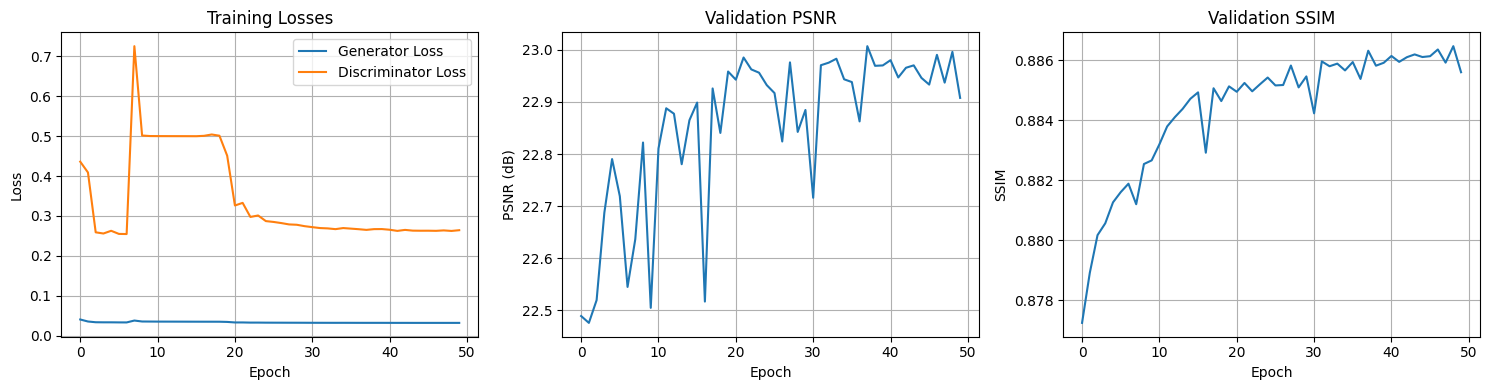


Training completed!

Training Baseline model (without CBAM)
Loaded 2103 image pairs from train set
Loaded 1111 image pairs from test set
Baseline Generator parameters: 3,338,243
Discriminator parameters: 5,531,266
Training baseline model (without CBAM)
Training samples: 2103
Validation samples: 1111
Output directory: /content/comparison_experiment/baseline
Starting training from epoch 0

Epoch 1/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.70it/s]



Validation Results:
  PSNR: 22.33 dB
  SSIM: 0.8732
Checkpoint saved to /content/comparison_experiment/baseline/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0448
  Discriminator Loss: 0.5608
  Validation PSNR: 22.33 dB
  Validation SSIM: 0.8732

Epoch 2/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.63it/s]



Validation Results:
  PSNR: 22.51 dB
  SSIM: 0.8753
Checkpoint saved to /content/comparison_experiment/baseline/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0360
  Discriminator Loss: 0.4127
  Validation PSNR: 22.51 dB
  Validation SSIM: 0.8753

Epoch 3/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.65it/s]



Validation Results:
  PSNR: 22.72 dB
  SSIM: 0.8787
Checkpoint saved to /content/comparison_experiment/baseline/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0339
  Discriminator Loss: 0.2620
  Validation PSNR: 22.72 dB
  Validation SSIM: 0.8787

Epoch 4/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.54it/s]



Validation Results:
  PSNR: 22.61 dB
  SSIM: 0.8791
Checkpoint saved to /content/comparison_experiment/baseline/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0337
  Discriminator Loss: 0.2699
  Validation PSNR: 22.61 dB
  Validation SSIM: 0.8791

Epoch 5/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.48it/s]



Validation Results:
  PSNR: 22.87 dB
  SSIM: 0.8826
Checkpoint saved to /content/comparison_experiment/baseline/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0334
  Discriminator Loss: 0.2549
  Validation PSNR: 22.87 dB
  Validation SSIM: 0.8826

Epoch 6/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.60it/s]



Validation Results:
  PSNR: 22.91 dB
  SSIM: 0.8832
Checkpoint saved to /content/comparison_experiment/baseline/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0397
  Discriminator Loss: 0.8642
  Validation PSNR: 22.91 dB
  Validation SSIM: 0.8832

Epoch 7/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.61it/s]



Validation Results:
  PSNR: 22.94 dB
  SSIM: 0.8841
Checkpoint saved to /content/comparison_experiment/baseline/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0357
  Discriminator Loss: 0.5019
  Validation PSNR: 22.94 dB
  Validation SSIM: 0.8841

Epoch 8/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.59it/s]



Validation Results:
  PSNR: 22.84 dB
  SSIM: 0.8837
Checkpoint saved to /content/comparison_experiment/baseline/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0355
  Discriminator Loss: 0.4925
  Validation PSNR: 22.84 dB
  Validation SSIM: 0.8837

Epoch 9/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.65it/s]



Validation Results:
  PSNR: 22.89 dB
  SSIM: 0.8836
Checkpoint saved to /content/comparison_experiment/baseline/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0336
  Discriminator Loss: 0.2865
  Validation PSNR: 22.89 dB
  Validation SSIM: 0.8836

Epoch 10/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.63it/s]



Validation Results:
  PSNR: 22.86 dB
  SSIM: 0.8847
Checkpoint saved to /content/comparison_experiment/baseline/checkpoints/epoch_10.pth
Checkpoint saved to /content/comparison_experiment/baseline/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0332
  Discriminator Loss: 0.2694
  Validation PSNR: 22.86 dB
  Validation SSIM: 0.8847

Epoch 11/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.74it/s]



Validation Results:
  PSNR: 22.90 dB
  SSIM: 0.8840
Checkpoint saved to /content/comparison_experiment/baseline/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0333
  Discriminator Loss: 0.2608
  Validation PSNR: 22.90 dB
  Validation SSIM: 0.8840

Epoch 12/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.61it/s]



Validation Results:
  PSNR: 22.87 dB
  SSIM: 0.8838
Checkpoint saved to /content/comparison_experiment/baseline/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0330
  Discriminator Loss: 0.2547
  Validation PSNR: 22.87 dB
  Validation SSIM: 0.8838

Epoch 13/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.59it/s]



Validation Results:
  PSNR: 22.94 dB
  SSIM: 0.8851
Checkpoint saved to /content/comparison_experiment/baseline/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0329
  Discriminator Loss: 0.2540
  Validation PSNR: 22.94 dB
  Validation SSIM: 0.8851

Epoch 14/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.71it/s]



Validation Results:
  PSNR: 22.96 dB
  SSIM: 0.8854
Checkpoint saved to /content/comparison_experiment/baseline/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0329
  Discriminator Loss: 0.2539
  Validation PSNR: 22.96 dB
  Validation SSIM: 0.8854

Epoch 15/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.62it/s]



Validation Results:
  PSNR: 22.93 dB
  SSIM: 0.8850
Checkpoint saved to /content/comparison_experiment/baseline/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0329
  Discriminator Loss: 0.2543
  Validation PSNR: 22.93 dB
  Validation SSIM: 0.8850

Epoch 16/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.68it/s]



Validation Results:
  PSNR: 22.96 dB
  SSIM: 0.8854
Checkpoint saved to /content/comparison_experiment/baseline/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0328
  Discriminator Loss: 0.2549
  Validation PSNR: 22.96 dB
  Validation SSIM: 0.8854

Epoch 17/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.68it/s]



Validation Results:
  PSNR: 22.96 dB
  SSIM: 0.8851
Checkpoint saved to /content/comparison_experiment/baseline/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0331
  Discriminator Loss: 0.2669
  Validation PSNR: 22.96 dB
  Validation SSIM: 0.8851

Epoch 18/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.57it/s]



Validation Results:
  PSNR: 23.00 dB
  SSIM: 0.8857
Checkpoint saved to /content/comparison_experiment/baseline/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0329
  Discriminator Loss: 0.2557
  Validation PSNR: 23.00 dB
  Validation SSIM: 0.8857

Epoch 19/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.75it/s]



Validation Results:
  PSNR: 22.94 dB
  SSIM: 0.8847
Checkpoint saved to /content/comparison_experiment/baseline/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0329
  Discriminator Loss: 0.2559
  Validation PSNR: 22.94 dB
  Validation SSIM: 0.8847

Epoch 20/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.78it/s]



Validation Results:
  PSNR: 22.98 dB
  SSIM: 0.8857
Checkpoint saved to /content/comparison_experiment/baseline/checkpoints/epoch_20.pth
Checkpoint saved to /content/comparison_experiment/baseline/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0328
  Discriminator Loss: 0.2567
  Validation PSNR: 22.98 dB
  Validation SSIM: 0.8857

Epoch 21/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.56it/s]



Validation Results:
  PSNR: 23.01 dB
  SSIM: 0.8859
Checkpoint saved to /content/comparison_experiment/baseline/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0327
  Discriminator Loss: 0.2516
  Validation PSNR: 23.01 dB
  Validation SSIM: 0.8859

Epoch 22/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.76it/s]



Validation Results:
  PSNR: 23.02 dB
  SSIM: 0.8859
Checkpoint saved to /content/comparison_experiment/baseline/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0327
  Discriminator Loss: 0.2520
  Validation PSNR: 23.02 dB
  Validation SSIM: 0.8859

Epoch 23/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.59it/s]



Validation Results:
  PSNR: 23.02 dB
  SSIM: 0.8860
Checkpoint saved to /content/comparison_experiment/baseline/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0327
  Discriminator Loss: 0.2517
  Validation PSNR: 23.02 dB
  Validation SSIM: 0.8860

Epoch 24/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.54it/s]



Validation Results:
  PSNR: 23.02 dB
  SSIM: 0.8860
Checkpoint saved to /content/comparison_experiment/baseline/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0327
  Discriminator Loss: 0.2517
  Validation PSNR: 23.02 dB
  Validation SSIM: 0.8860

Epoch 25/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.68it/s]



Validation Results:
  PSNR: 23.03 dB
  SSIM: 0.8863
Checkpoint saved to /content/comparison_experiment/baseline/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0327
  Discriminator Loss: 0.2523
  Validation PSNR: 23.03 dB
  Validation SSIM: 0.8863

Epoch 26/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.53it/s]



Validation Results:
  PSNR: 23.04 dB
  SSIM: 0.8862
Checkpoint saved to /content/comparison_experiment/baseline/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0326
  Discriminator Loss: 0.2529
  Validation PSNR: 23.04 dB
  Validation SSIM: 0.8862

Epoch 27/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.73it/s]



Validation Results:
  PSNR: 23.04 dB
  SSIM: 0.8865
Checkpoint saved to /content/comparison_experiment/baseline/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0326
  Discriminator Loss: 0.2532
  Validation PSNR: 23.04 dB
  Validation SSIM: 0.8865

Epoch 28/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.58it/s]



Validation Results:
  PSNR: 23.04 dB
  SSIM: 0.8867
Checkpoint saved to /content/comparison_experiment/baseline/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0326
  Discriminator Loss: 0.2521
  Validation PSNR: 23.04 dB
  Validation SSIM: 0.8867

Epoch 29/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.61it/s]



Validation Results:
  PSNR: 23.04 dB
  SSIM: 0.8866
Checkpoint saved to /content/comparison_experiment/baseline/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0326
  Discriminator Loss: 0.2538
  Validation PSNR: 23.04 dB
  Validation SSIM: 0.8866

Epoch 30/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.52it/s]



Validation Results:
  PSNR: 23.03 dB
  SSIM: 0.8862
Checkpoint saved to /content/comparison_experiment/baseline/checkpoints/epoch_30.pth
Checkpoint saved to /content/comparison_experiment/baseline/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0326
  Discriminator Loss: 0.2532
  Validation PSNR: 23.03 dB
  Validation SSIM: 0.8862

Epoch 31/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.63it/s]



Validation Results:
  PSNR: 23.04 dB
  SSIM: 0.8863
Checkpoint saved to /content/comparison_experiment/baseline/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0325
  Discriminator Loss: 0.2510
  Validation PSNR: 23.04 dB
  Validation SSIM: 0.8863

Epoch 32/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.76it/s]



Validation Results:
  PSNR: 23.03 dB
  SSIM: 0.8861
Checkpoint saved to /content/comparison_experiment/baseline/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0325
  Discriminator Loss: 0.2509
  Validation PSNR: 23.03 dB
  Validation SSIM: 0.8861

Epoch 33/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.52it/s]



Validation Results:
  PSNR: 23.05 dB
  SSIM: 0.8868
Checkpoint saved to /content/comparison_experiment/baseline/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0325
  Discriminator Loss: 0.2510
  Validation PSNR: 23.05 dB
  Validation SSIM: 0.8868

Epoch 34/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.57it/s]



Validation Results:
  PSNR: 23.04 dB
  SSIM: 0.8865
Checkpoint saved to /content/comparison_experiment/baseline/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0325
  Discriminator Loss: 0.2510
  Validation PSNR: 23.04 dB
  Validation SSIM: 0.8865

Epoch 35/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.70it/s]



Validation Results:
  PSNR: 23.04 dB
  SSIM: 0.8867
Checkpoint saved to /content/comparison_experiment/baseline/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0325
  Discriminator Loss: 0.2508
  Validation PSNR: 23.04 dB
  Validation SSIM: 0.8867

Epoch 36/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.71it/s]



Validation Results:
  PSNR: 23.05 dB
  SSIM: 0.8870
Checkpoint saved to /content/comparison_experiment/baseline/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0325
  Discriminator Loss: 0.2511
  Validation PSNR: 23.05 dB
  Validation SSIM: 0.8870

Epoch 37/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.66it/s]



Validation Results:
  PSNR: 23.04 dB
  SSIM: 0.8867
Checkpoint saved to /content/comparison_experiment/baseline/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0325
  Discriminator Loss: 0.2516
  Validation PSNR: 23.04 dB
  Validation SSIM: 0.8867

Epoch 38/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.60it/s]



Validation Results:
  PSNR: 23.05 dB
  SSIM: 0.8866
Checkpoint saved to /content/comparison_experiment/baseline/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0324
  Discriminator Loss: 0.2510
  Validation PSNR: 23.05 dB
  Validation SSIM: 0.8866

Epoch 39/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.51it/s]



Validation Results:
  PSNR: 23.04 dB
  SSIM: 0.8867
Checkpoint saved to /content/comparison_experiment/baseline/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0324
  Discriminator Loss: 0.2513
  Validation PSNR: 23.04 dB
  Validation SSIM: 0.8867

Epoch 40/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.75it/s]



Validation Results:
  PSNR: 23.07 dB
  SSIM: 0.8870
Checkpoint saved to /content/comparison_experiment/baseline/checkpoints/epoch_40.pth
Checkpoint saved to /content/comparison_experiment/baseline/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0324
  Discriminator Loss: 0.2512
  Validation PSNR: 23.07 dB
  Validation SSIM: 0.8870

Epoch 41/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.59it/s]



Validation Results:
  PSNR: 23.06 dB
  SSIM: 0.8869
Checkpoint saved to /content/comparison_experiment/baseline/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0324
  Discriminator Loss: 0.2506
  Validation PSNR: 23.06 dB
  Validation SSIM: 0.8869

Epoch 42/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.70it/s]



Validation Results:
  PSNR: 23.05 dB
  SSIM: 0.8868
Checkpoint saved to /content/comparison_experiment/baseline/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0324
  Discriminator Loss: 0.2505
  Validation PSNR: 23.05 dB
  Validation SSIM: 0.8868

Epoch 43/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.63it/s]



Validation Results:
  PSNR: 23.07 dB
  SSIM: 0.8870
Checkpoint saved to /content/comparison_experiment/baseline/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0324
  Discriminator Loss: 0.2506
  Validation PSNR: 23.07 dB
  Validation SSIM: 0.8870

Epoch 44/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.67it/s]



Validation Results:
  PSNR: 23.06 dB
  SSIM: 0.8868
Checkpoint saved to /content/comparison_experiment/baseline/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0324
  Discriminator Loss: 0.2506
  Validation PSNR: 23.06 dB
  Validation SSIM: 0.8868

Epoch 45/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.49it/s]



Validation Results:
  PSNR: 23.06 dB
  SSIM: 0.8869
Checkpoint saved to /content/comparison_experiment/baseline/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0324
  Discriminator Loss: 0.2506
  Validation PSNR: 23.06 dB
  Validation SSIM: 0.8869

Epoch 46/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.59it/s]



Validation Results:
  PSNR: 23.06 dB
  SSIM: 0.8870
Checkpoint saved to /content/comparison_experiment/baseline/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0324
  Discriminator Loss: 0.2506
  Validation PSNR: 23.06 dB
  Validation SSIM: 0.8870

Epoch 47/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.50it/s]



Validation Results:
  PSNR: 23.06 dB
  SSIM: 0.8869
Checkpoint saved to /content/comparison_experiment/baseline/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0324
  Discriminator Loss: 0.2506
  Validation PSNR: 23.06 dB
  Validation SSIM: 0.8869

Epoch 48/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.63it/s]



Validation Results:
  PSNR: 23.06 dB
  SSIM: 0.8870
Checkpoint saved to /content/comparison_experiment/baseline/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0324
  Discriminator Loss: 0.2506
  Validation PSNR: 23.06 dB
  Validation SSIM: 0.8870

Epoch 49/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.60it/s]



Validation Results:
  PSNR: 23.06 dB
  SSIM: 0.8868
Checkpoint saved to /content/comparison_experiment/baseline/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0324
  Discriminator Loss: 0.2506
  Validation PSNR: 23.06 dB
  Validation SSIM: 0.8868

Epoch 50/50


Validating: 100%|██████████| 139/139 [00:14<00:00,  9.59it/s]



Validation Results:
  PSNR: 23.06 dB
  SSIM: 0.8870
Checkpoint saved to /content/comparison_experiment/baseline/checkpoints/epoch_50.pth
Checkpoint saved to /content/comparison_experiment/baseline/checkpoints/latest.pth

Epoch Summary:
  Generator Loss: 0.0323
  Discriminator Loss: 0.2505
  Validation PSNR: 23.06 dB
  Validation SSIM: 0.8870


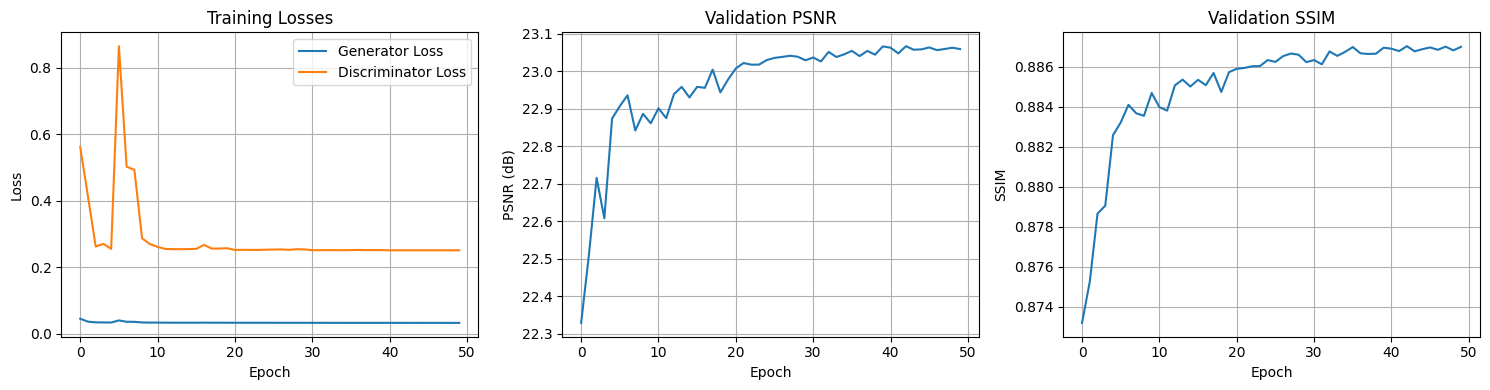


Training completed!

Training completed for both models


In [20]:
print("Starting comparative training...")
experiment.train_models(num_epochs=50)

In [21]:
print("\nEvaluating models...")
cbam_psnr, cbam_ssim, baseline_psnr, baseline_ssim = experiment.evaluate_models()


Evaluating models...

Evaluating both models on test set
Generator parameters: 3,365,385
Discriminator parameters: 5,531,266
Checkpoint loaded from /content/comparison_experiment/cbam/checkpoints/latest.pth, epoch 50
Baseline Generator parameters: 3,338,243
Discriminator parameters: 5,531,266
Checkpoint loaded from /content/comparison_experiment/baseline/checkpoints/latest.pth, epoch 50


Evaluating: 100%|██████████| 139/139 [00:36<00:00,  3.80it/s]


MODEL COMPARISON RESULTS
Metric          CBAM Model      Baseline Model  Improvement    
------------------------------------------------------------
PSNR (dB)       28.76           28.92           -0.15
SSIM            0.8776          0.8790          -0.0014
Parameters      3,365,385       3,338,243       +27,142



Visualizing comparison...

Visualizing comparison on 3 samples
Generator parameters: 3,365,385
Discriminator parameters: 5,531,266
Checkpoint loaded from /content/comparison_experiment/cbam/checkpoints/latest.pth, epoch 50
Baseline Generator parameters: 3,338,243
Discriminator parameters: 5,531,266
Checkpoint loaded from /content/comparison_experiment/baseline/checkpoints/latest.pth, epoch 50


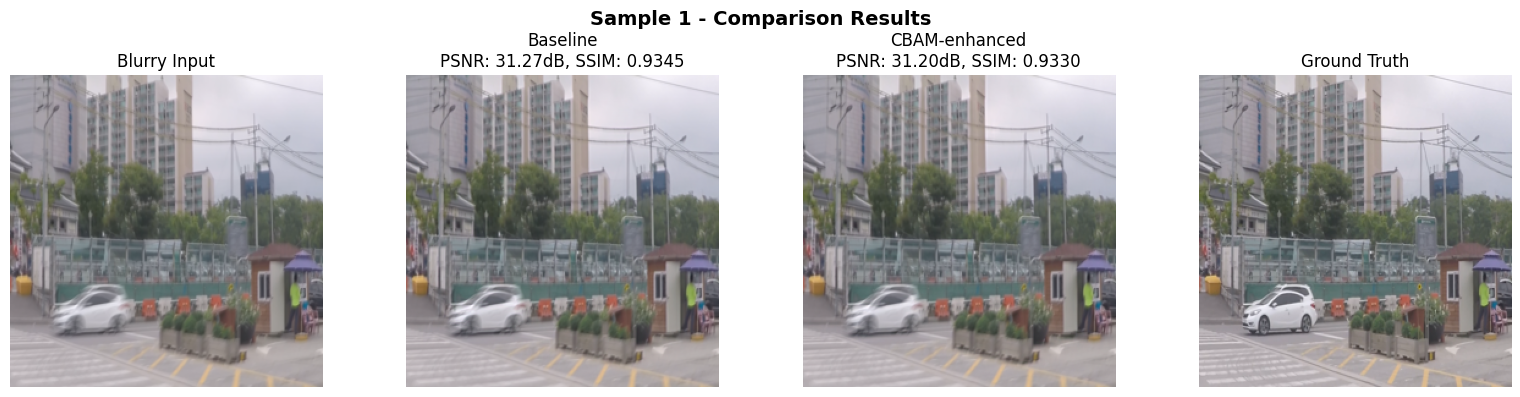

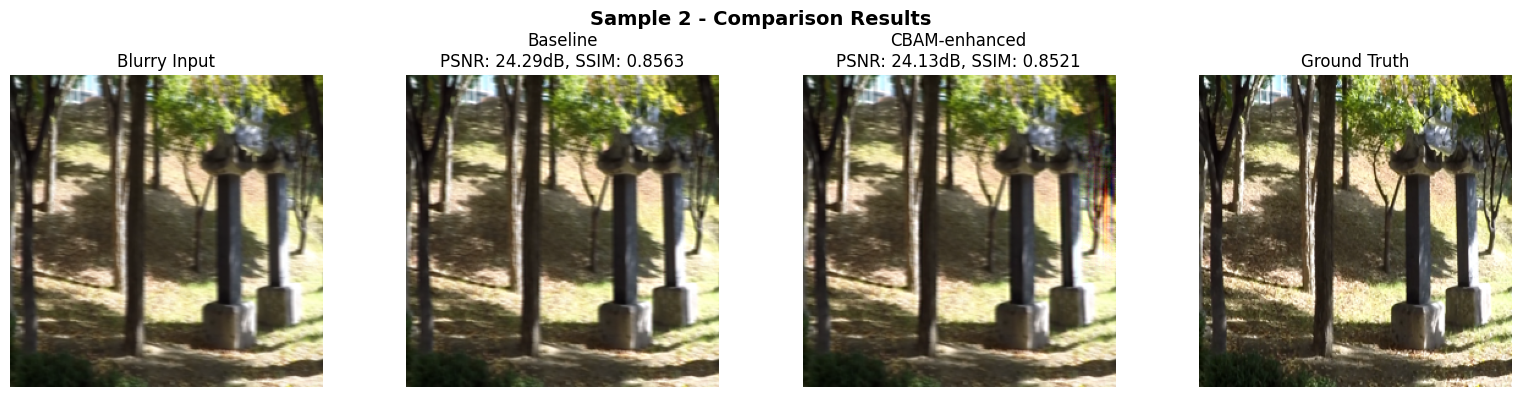

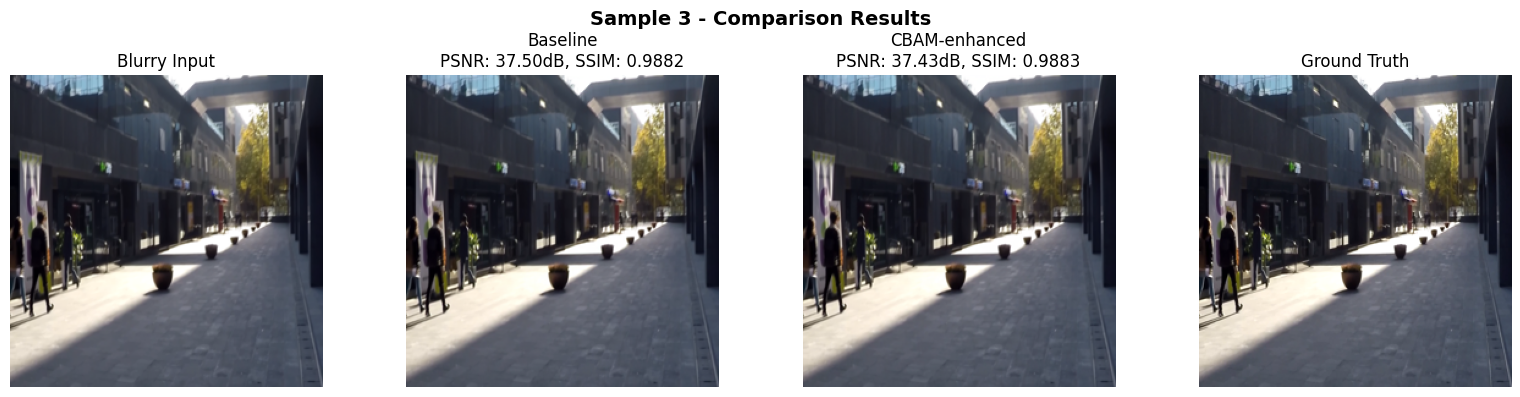

In [22]:
print("\nVisualizing comparison...")
experiment.visualize_comparison(num_samples=3)


Plotting training curves...


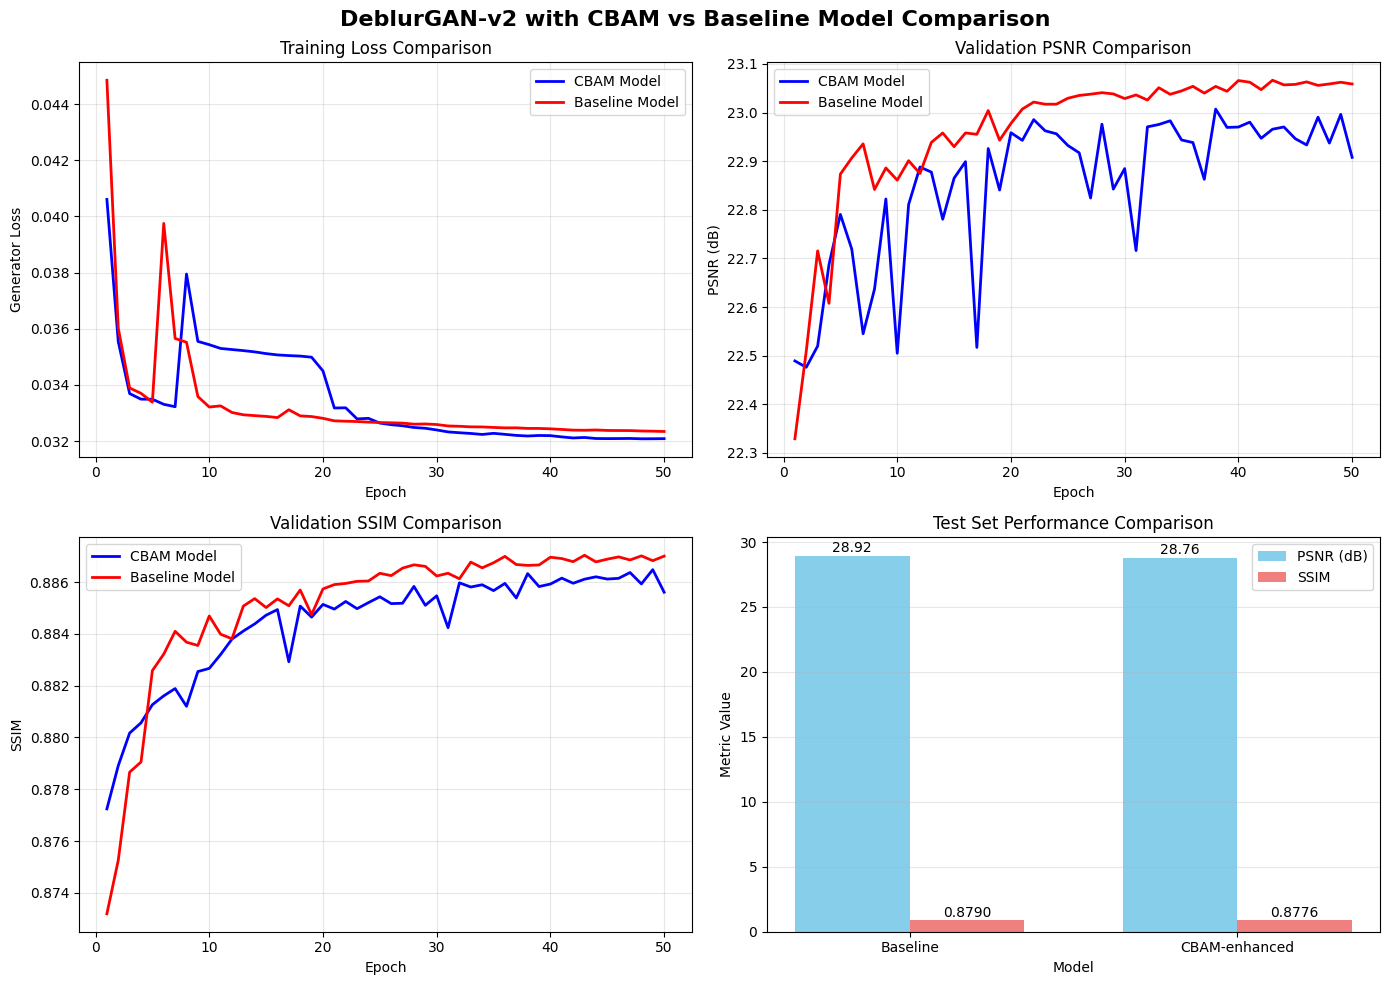

Comparison results saved to: /content/comparison_experiment/comparison_results.png


In [23]:
print("\nPlotting training curves...")
experiment.plot_training_curves()

In [24]:
print("\nGenerating comparison report...")
report = experiment.generate_comparison_report()


Generating comparison report...

        DEBLURGAN-V2 WITH CBAM VS BASELINE - COMPARISON REPORT

        Model Specifications:
        --------------------
        CBAM-enhanced Model:
        - Parameters: 3,365,385
        - CBAM Modules: Enabled
        - Backbone: MobileNetV2 with integrated CBAM

        Baseline Model:
        - Parameters: 3,338,243
        - CBAM Modules: Disabled
        - Backbone: Standard MobileNetV2

        Training Configuration:
        ----------------------
        - Epochs: 50
        - Batch Size: 8
        - Learning Rate (G): 0.0001
        - Learning Rate (D): 0.0004
        - Image Size: 256x256

        Performance Results:
        -------------------
        Test Set Performance (averaged over 1111 images):

        Metric          CBAM Model      Baseline Model  Improvement     % Improvement  
        --------------- --------------- --------------- --------------- ---------------
        PSNR (dB)       28.76           28.92          
      